<img src="./images/blockcheck.png" width="300" align="left" />

# Bitcoin Ponzi Scheme Classification

Jarred van de Voort and Sean Coneys

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
%matplotlib inline

#method used for preprocessing
from sklearn.preprocessing import StandardScaler

#models used for training/fitting data
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
import xgboost

#methods for training and optimizing model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, auc,roc_auc_score,roc_curve, precision_recall_curve
from sklearn.metrics import average_precision_score,confusion_matrix,precision_recall_curve,auc,roc_curve,recall_score,classification_report 

#methods for resampling
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids,NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.ensemble import BalanceCascade

#ensemble methods
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

## I. Data Exploration

### Ponzi Scheme Transaction History

Using a public API, we're able to derive all transactions to and from a given address. The following dataset is series of transactions associated with a large ponzi scheme known as "Leancy". 

In [2]:
df_ponzi = pd.read_csv('datasets/leancy_txhistory.csv')
df_ponzi['date'] = pd.to_datetime(df_ponzi['date'].astype(str), format='%Y%m%d')
df_ponzi.head(10)

date              desc    btc_in    btc_out  \
0 2017-11-23  PAYMENT RECEIVED  0.009904   0.000000   
1 2014-12-21  PAYMENT RECEIVED  0.000100   0.000000   
2 2014-11-25      PAYMENT SENT  0.000000  -0.263058   
3 2014-11-13  PAYMENT RECEIVED  0.000200   0.000000   
4 2014-08-24  PAYMENT RECEIVED  0.000200   0.000000   
5 2014-08-21  PAYMENT RECEIVED  0.000200   0.000000   
6 2014-07-29  PAYMENT RECEIVED  0.254598   0.000000   
7 2014-03-31      PAYMENT SENT  0.000000 -19.001000   
8 2014-03-24  PAYMENT RECEIVED  0.040000   0.000000   
9 2014-03-31      PAYMENT SENT  0.000000  -0.890700   

                                                hash        bal  
0  bf6ccbeb7c2fa0535f3229c9f5ab8412642deb718e281a...   0.010004  
1  9dd64803261aa39e63070aad206d57a6c1886303300f36...   0.000100  
2  d35416dba2ae6dadd7df9fe57f2200b15ff7f1e7dea758...   0.000000  
3  a27e9ca7c93be1ced371299d648181e15ba2a8d1dbd36f...   0.263058  
4  08a623800a875a86e29c2205dbfc01efa43e083a9d7b67...   0.262858  
5  89db8804304d0c42a60f39bbfba52c7f143bb5a225f60b...   0.262658  
6  d581a9f30bf5d95b661acb5b64319a45988d6c12b64874...   0.262458  
7  f7f7148f624aeff97512750c86a24cf62b9c6be3a1023e...   0.007860  
8  52dfa32d5737e7bbc07e31a1f71dba1bf911ae6aca941c...  19.899560  
9  f28667cc054d6078a2192aa4d99d995d438a024fe9016f...  19.008860

To motivate this problem, let's take a look at the total number of transactions and BTC in/out to get a sense of scale.

In [3]:
print('NUM TRANSACTIONS: ' + str(len(df_ponzi)))
print('MAX BAL: BTC ' + str(df_ponzi['bal'].max()))
df_ponzi['desc'].value_counts()

NUM TRANSACTIONS: 24707
MAX BAL: BTC 134.26823380000002


PAYMENT SENT        17805
PAYMENT RECEIVED     6902
Name: desc, dtype: int64

At its peak, Leancy had 134 BTC, roughly the equivalent of 500,000 USD, and saw 24,000 transactions over the lifetime of the scam. The number of payments recieved indicates that thousands of investors were involved. To get a better sense of the flow of currency in and out, we can plot balance and transactions over time. 

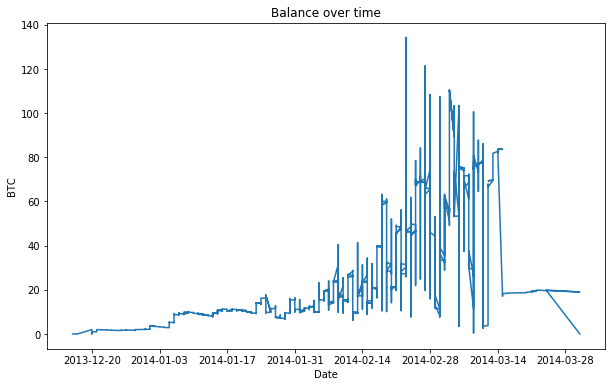

In [4]:
plt.figure(figsize=(10,6))
date_range = (df_ponzi['date'] > '2013-1-1') & (df_ponzi['date'] <= '2014-4-1')

df_daterange = df_ponzi[date_range]
plt.title("Balance over time")
plt.xlabel("Date")
plt.ylabel("BTC")
plt.plot(df_daterange['date'], df_daterange['bal'])

The figure above shows frequent fluctuation in the total balance of the address, which is consistent with the behaviour that ponzi schemes use funds from new investors to pay old investors at a high cadence. 

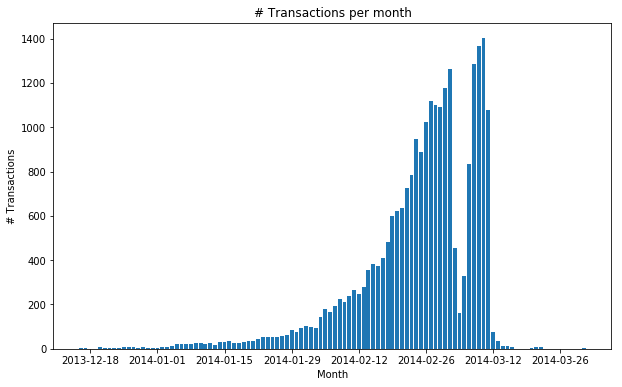

In [5]:
plt.figure(figsize=(10,6))
counts = df_daterange['date'].value_counts(sort=False)
plt.title("# Transactions per month")
plt.xlabel("Month")
plt.ylabel("# Transactions")
plt.bar(counts.index,counts)
plt.show()

Similarly, the number of transactions scales as the number of investors continues to increase. The scheme implodes when no more new funding can be secured to pay off old investors. The graph shows that after the third month, the number of transactions drops off significantly, indicating the collapse of the Leancy ponzi scheme.

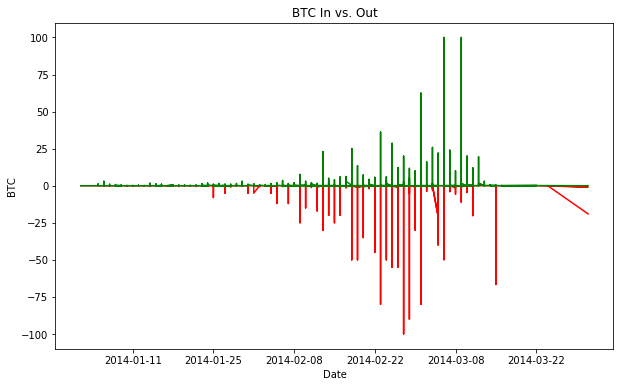

In [6]:
plt.figure(figsize=(10,6))
date_range = (df_ponzi['date'] > '2014-1-1') & (df_ponzi['date'] <= '2014-4-1')
df_inout = df_ponzi[date_range]

plt.title("BTC In vs. Out")
plt.xlabel("Date")
plt.ylabel("BTC")
plt.plot(df_inout['date'], df_inout['btc_out'],'r',df_inout['date'], df_inout['btc_in'],'g')

Separating BTC in vs. out tells us much of the same story. In this graph we can see that in the days leading up to the collapse, the amount of incoming BTC fell below the mark needed sustain the next level of growth

### Our Dataset

The first step in collecting data associated with ponzi schemes required an incredibly manual process of extracting data from several of forums that advertised "high yield investment programs" disguised as ponzi schemes. Some of these sites include [bitcoinwhoiswho.com](https://bitcoinwhoswho.com/), [bitcointalk.org](https://bitcointalk.org/), and [reddit.com](https://reddit.com/). The other class of non-ponzi schemes consists of 3000 randomly chosen addresses derived from this [study](https://arxiv.org/pdf/1803.00646.pdf). 

In [7]:
df = pd.read_csv('datasets/final_aggregated_dataset.csv')
df.head(10)

address   lifetime  most_active_day  \
0  15fcEUmKXBiScw2CDwKEre2YE8brvWPxVA    2051098                5   
1  121E9w1ogmjowDbJmkmCuqqQGztJteR78A   76904856                4   
2  12Hd6yd28NXoLuBYwqfncv3J7xXQnKKhGb  178822511                8   
3  166uYUb7ogk1xyxSSYQzdXRefdbYJaMTjs     934241                8   
4  16Zf5yBa2BhitYZMdENxAfkPs244YTG7y4     706251               13   
5  17wLBifUVkmAovSbVGJcXTvsgUiSMa1rjx   60486384                2   
6  1EyzXkzD4bRRJFwWs48rhtwe6WsE8bxARJ   69263235                2   
7  14XDyg1YkQFEkjJEHGYS1x3MSGEnhhATtH    3669366                9   
8  19QgdEbau15zQVNoTuMHtRRz4nsYv7mgSy    4484595                3   
9  1PkiFqu4w85DDvZ1bTgyPKijw99bpHz3dD   72575041                2   

   activity_days  in_vs_out  num_in  num_out  median_delay     mean_delay  \
0             15  33.000000      33        1         165.0     165.000000   
1             87   2.793103      81       29       29040.0   60882.000000   
2            118  39.600000     198        5        8595.0    8595.000000   
3             10   7.750000      31        4        5365.0    8232.500000   
4              8   1.285714      18       14        2812.0   41064.250000   
5             23   6.500000      26        4       28461.5   28461.500000   
6             29   3.428571      24        7      118027.0  148656.500000   
7             22  21.000000      42        2       30455.5   30455.500000   
8             22   7.666667      23        3        3040.0    4172.666667   
9             37   6.800000      34        5      520821.0  520821.000000   

   max_delay  min_delay  total_sent  total_recv    avg_out     avg_in  \
0        165        165    0.100000    7.450000   0.100000   0.225758   
1     278857       2981  141.577703  141.577703   4.881990   1.747873   
2       8595       8595   10.053716   30.876715   2.010743   0.155943   
3      22200          0  106.170000  106.170000  26.542500   3.424839   
4     259088        647  330.770000  330.770000  23.626429  18.376111   
5      40186      16737   20.350000   20.830000   5.087500   0.801154   
6     340869      17703   61.452890   61.452890   8.778984   2.560537   
7      52904       8007    2.470000    2.770000   1.235000   0.065952   
8       7479       1999    4.030000    4.120000   1.343333   0.179130   
9     520821     520821    1.130000    1.150000   0.138000   0.020882   

     max_diff  addresses_in_out  class  
0    7.450000                 0      0  
1  141.577703                 0      0  
2   30.876715                 0      0  
3  106.170000                 0      0  
4  330.770000                 1      0  
5   20.830000                 0      0  
6   61.452890                 0      0  
7    2.770000                 0      0  
8    4.120000                 0      0  
9    0.710000                 0      0

## II. Preprocessing & Exploration

In [8]:
df = df.drop('address', 1)
X = df.iloc[:, df.columns != 'class']
y = df.iloc[:, df.columns == 'class']

Since we manually calculated our features, most of the data cleaning is already handled for us. The full feature calculation pipeline can be viewed in the project repository. 

Let's take a look at our data by visualizing the distrubution of some of our features:

Text(0,0.5,'Frequency')

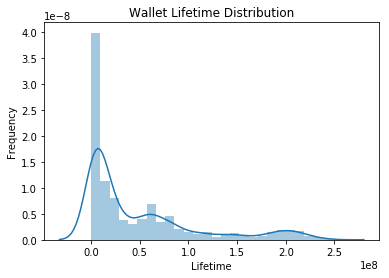

In [9]:
ax = sns.distplot(df['lifetime']);
ax.set_title('Wallet Lifetime Distribution')
ax.set_xlabel('Lifetime')
ax.set_ylabel('Frequency')

Text(0,0.5,'Total in_vs_out')

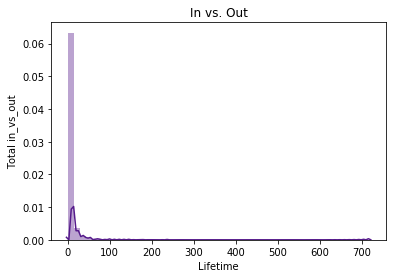

In [10]:
ax = sns.distplot(df['in_vs_out'], color = '#551a8b');
ax.set_title('In vs. Out')
ax.set_xlabel('Lifetime')
ax.set_ylabel('Total in_vs_out')

Shown above we have the distributions for lifetime and in/out of an address. It's clear that our data suffers from a high amount of skew. We can use a pairplot to visualize skewness in our feature matrix.

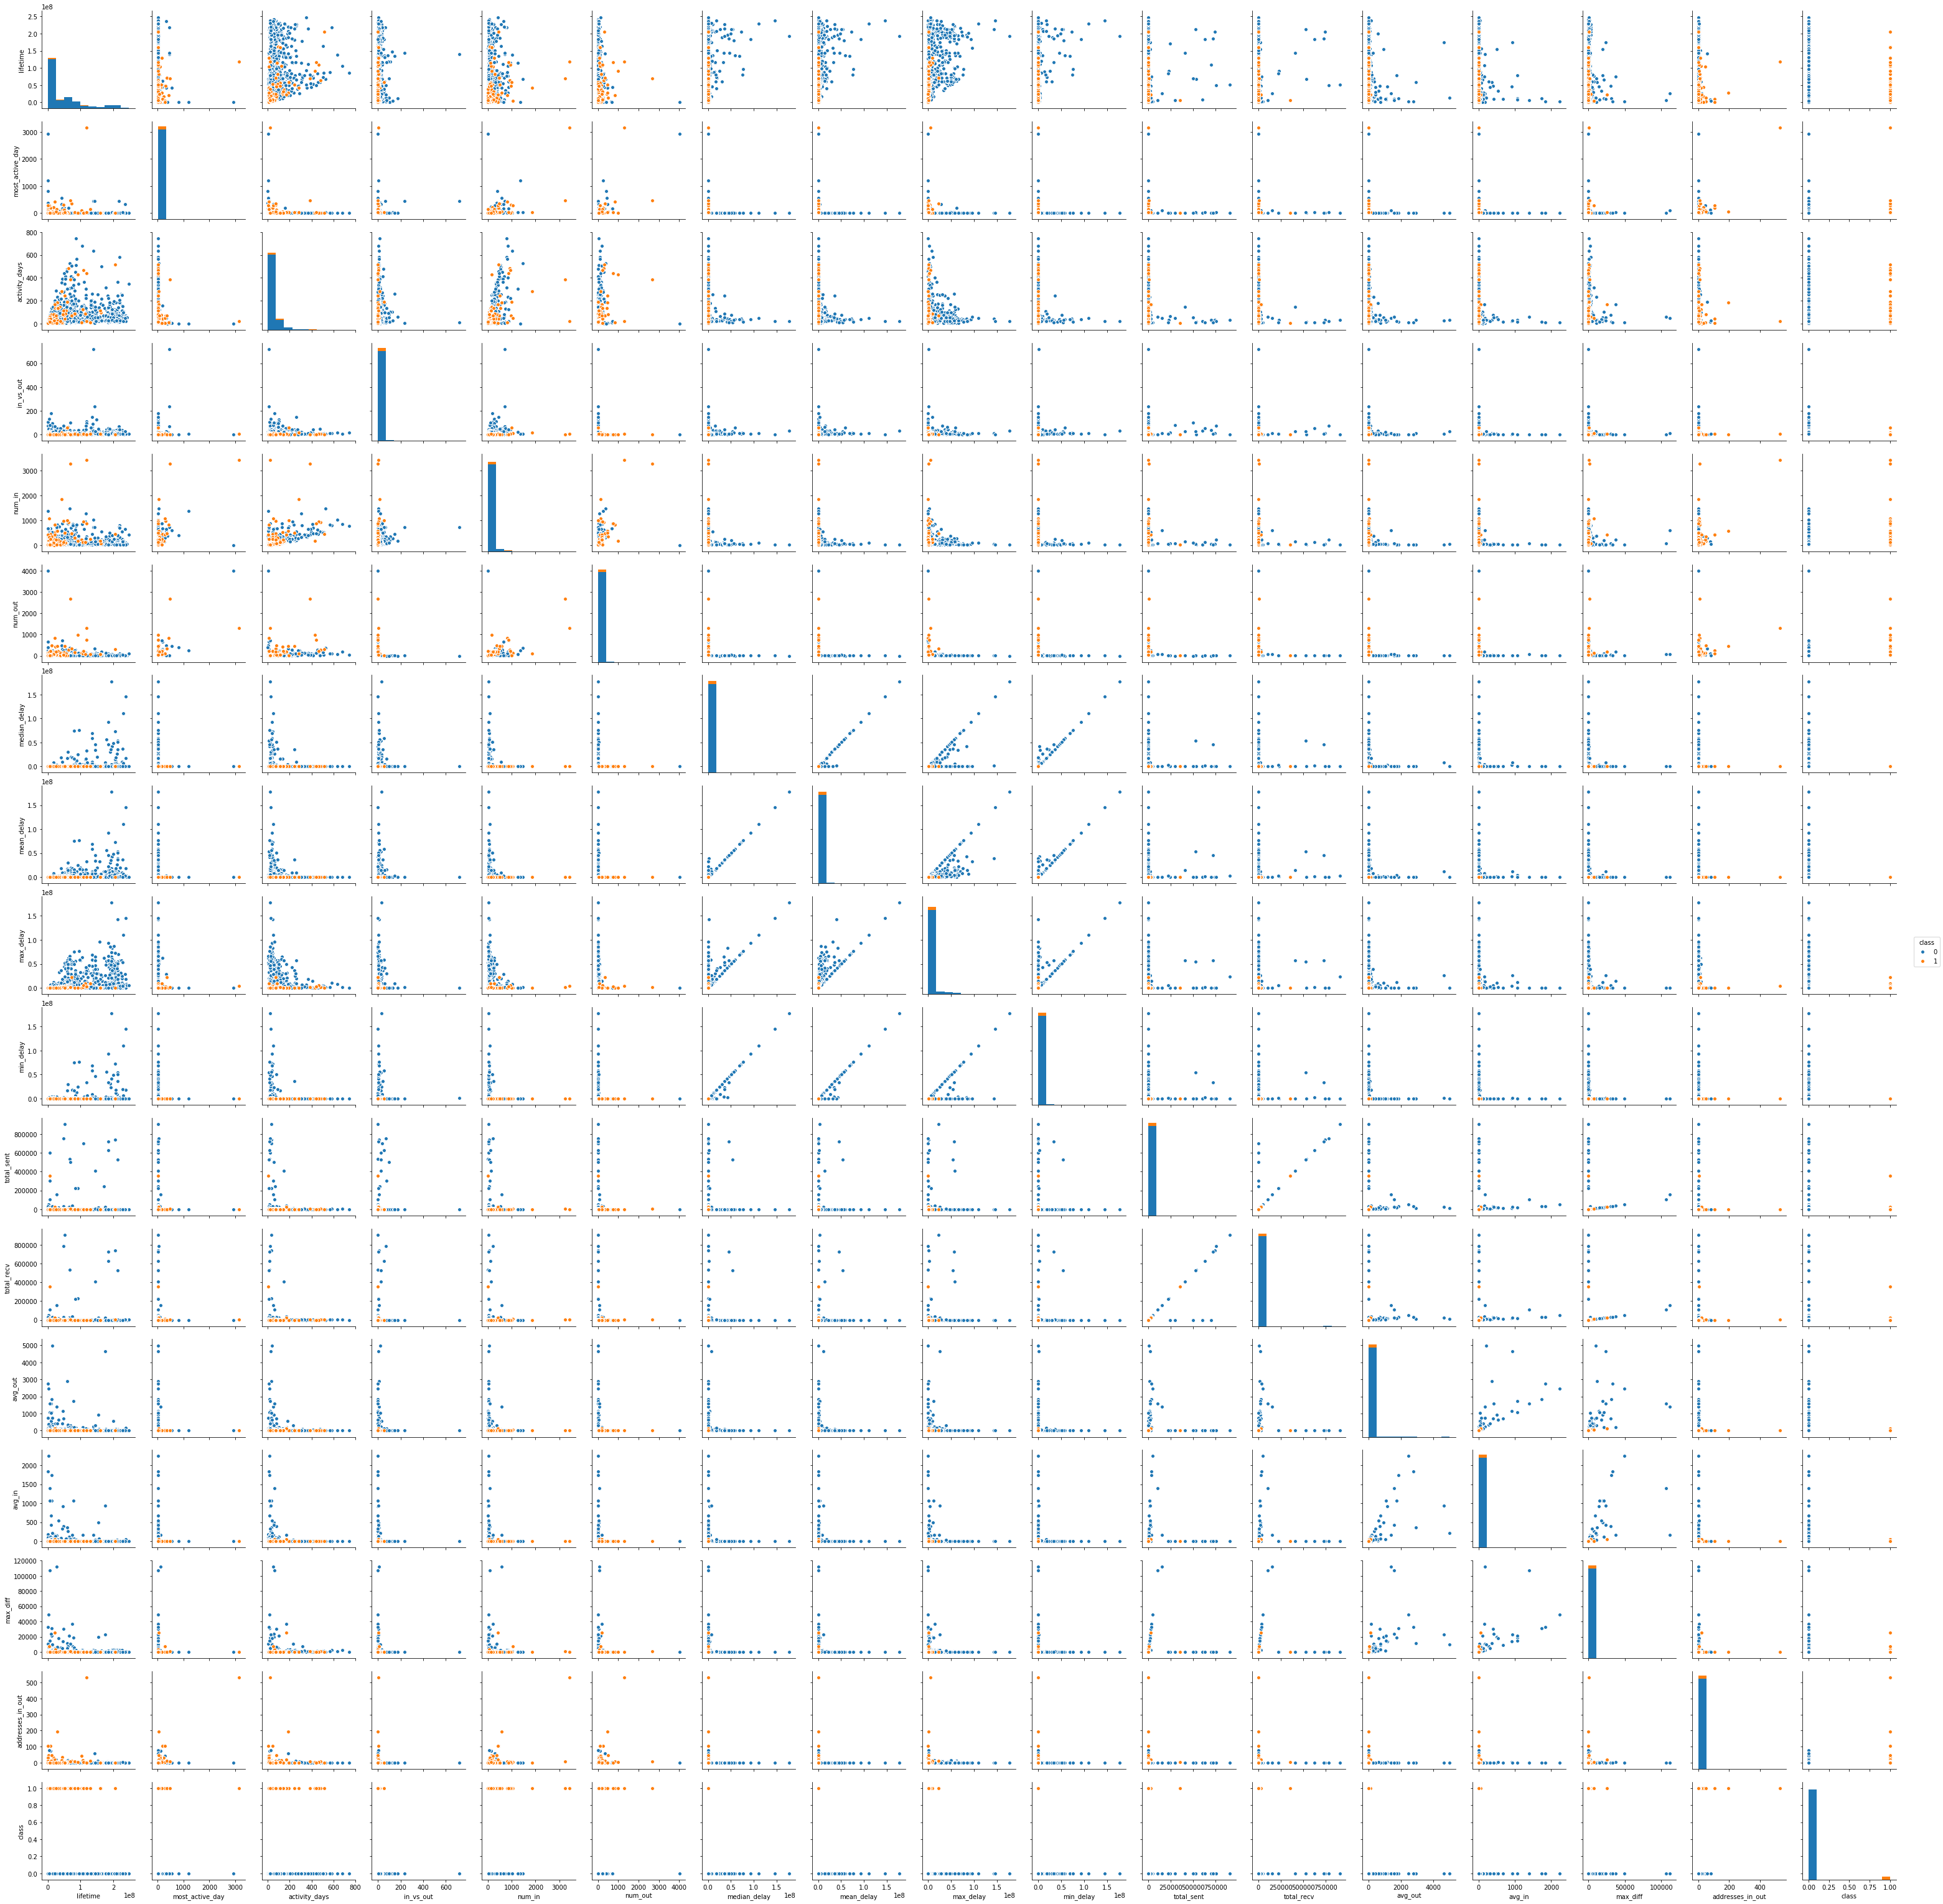

In [11]:
sns.pairplot(data=df, hue = 'class')

#### Handling Skewed Data
As suspected, most of our features are highly skewed, which will likely affect performance during training. Let's investigate the level of skewness for each feature using scipy's skew package.

In [13]:
from scipy.stats import skew
skewed_feats = X[X.dtypes.index].apply(lambda x: skew(x.dropna())).sort_values(ascending=False) 

skewed_df = pd.DataFrame({'Skew' :skewed_feats})
skewed_df.head(16)

Skew
addresses_in_out  33.462967
most_active_day   25.465184
in_vs_out         23.333182
num_out           22.904477
max_diff          20.741381
avg_out           16.799152
total_recv        16.664115
avg_in            16.026179
min_delay         15.141559
median_delay      13.953184
total_sent        13.883335
mean_delay        12.776714
num_in             9.409625
max_delay          5.486030
activity_days      4.391385
lifetime           1.500693

We can take the log of our features to help rebalance our feature distributions. In this case, we'll use numpy's log1p which returns $log(1 + x)$ where $x$ is the feature value:

In [14]:
X[skewed_df.index] = np.log1p(X[skewed_df.index])

To see the effect of this transformation, let's visualize our feature matrix once again:

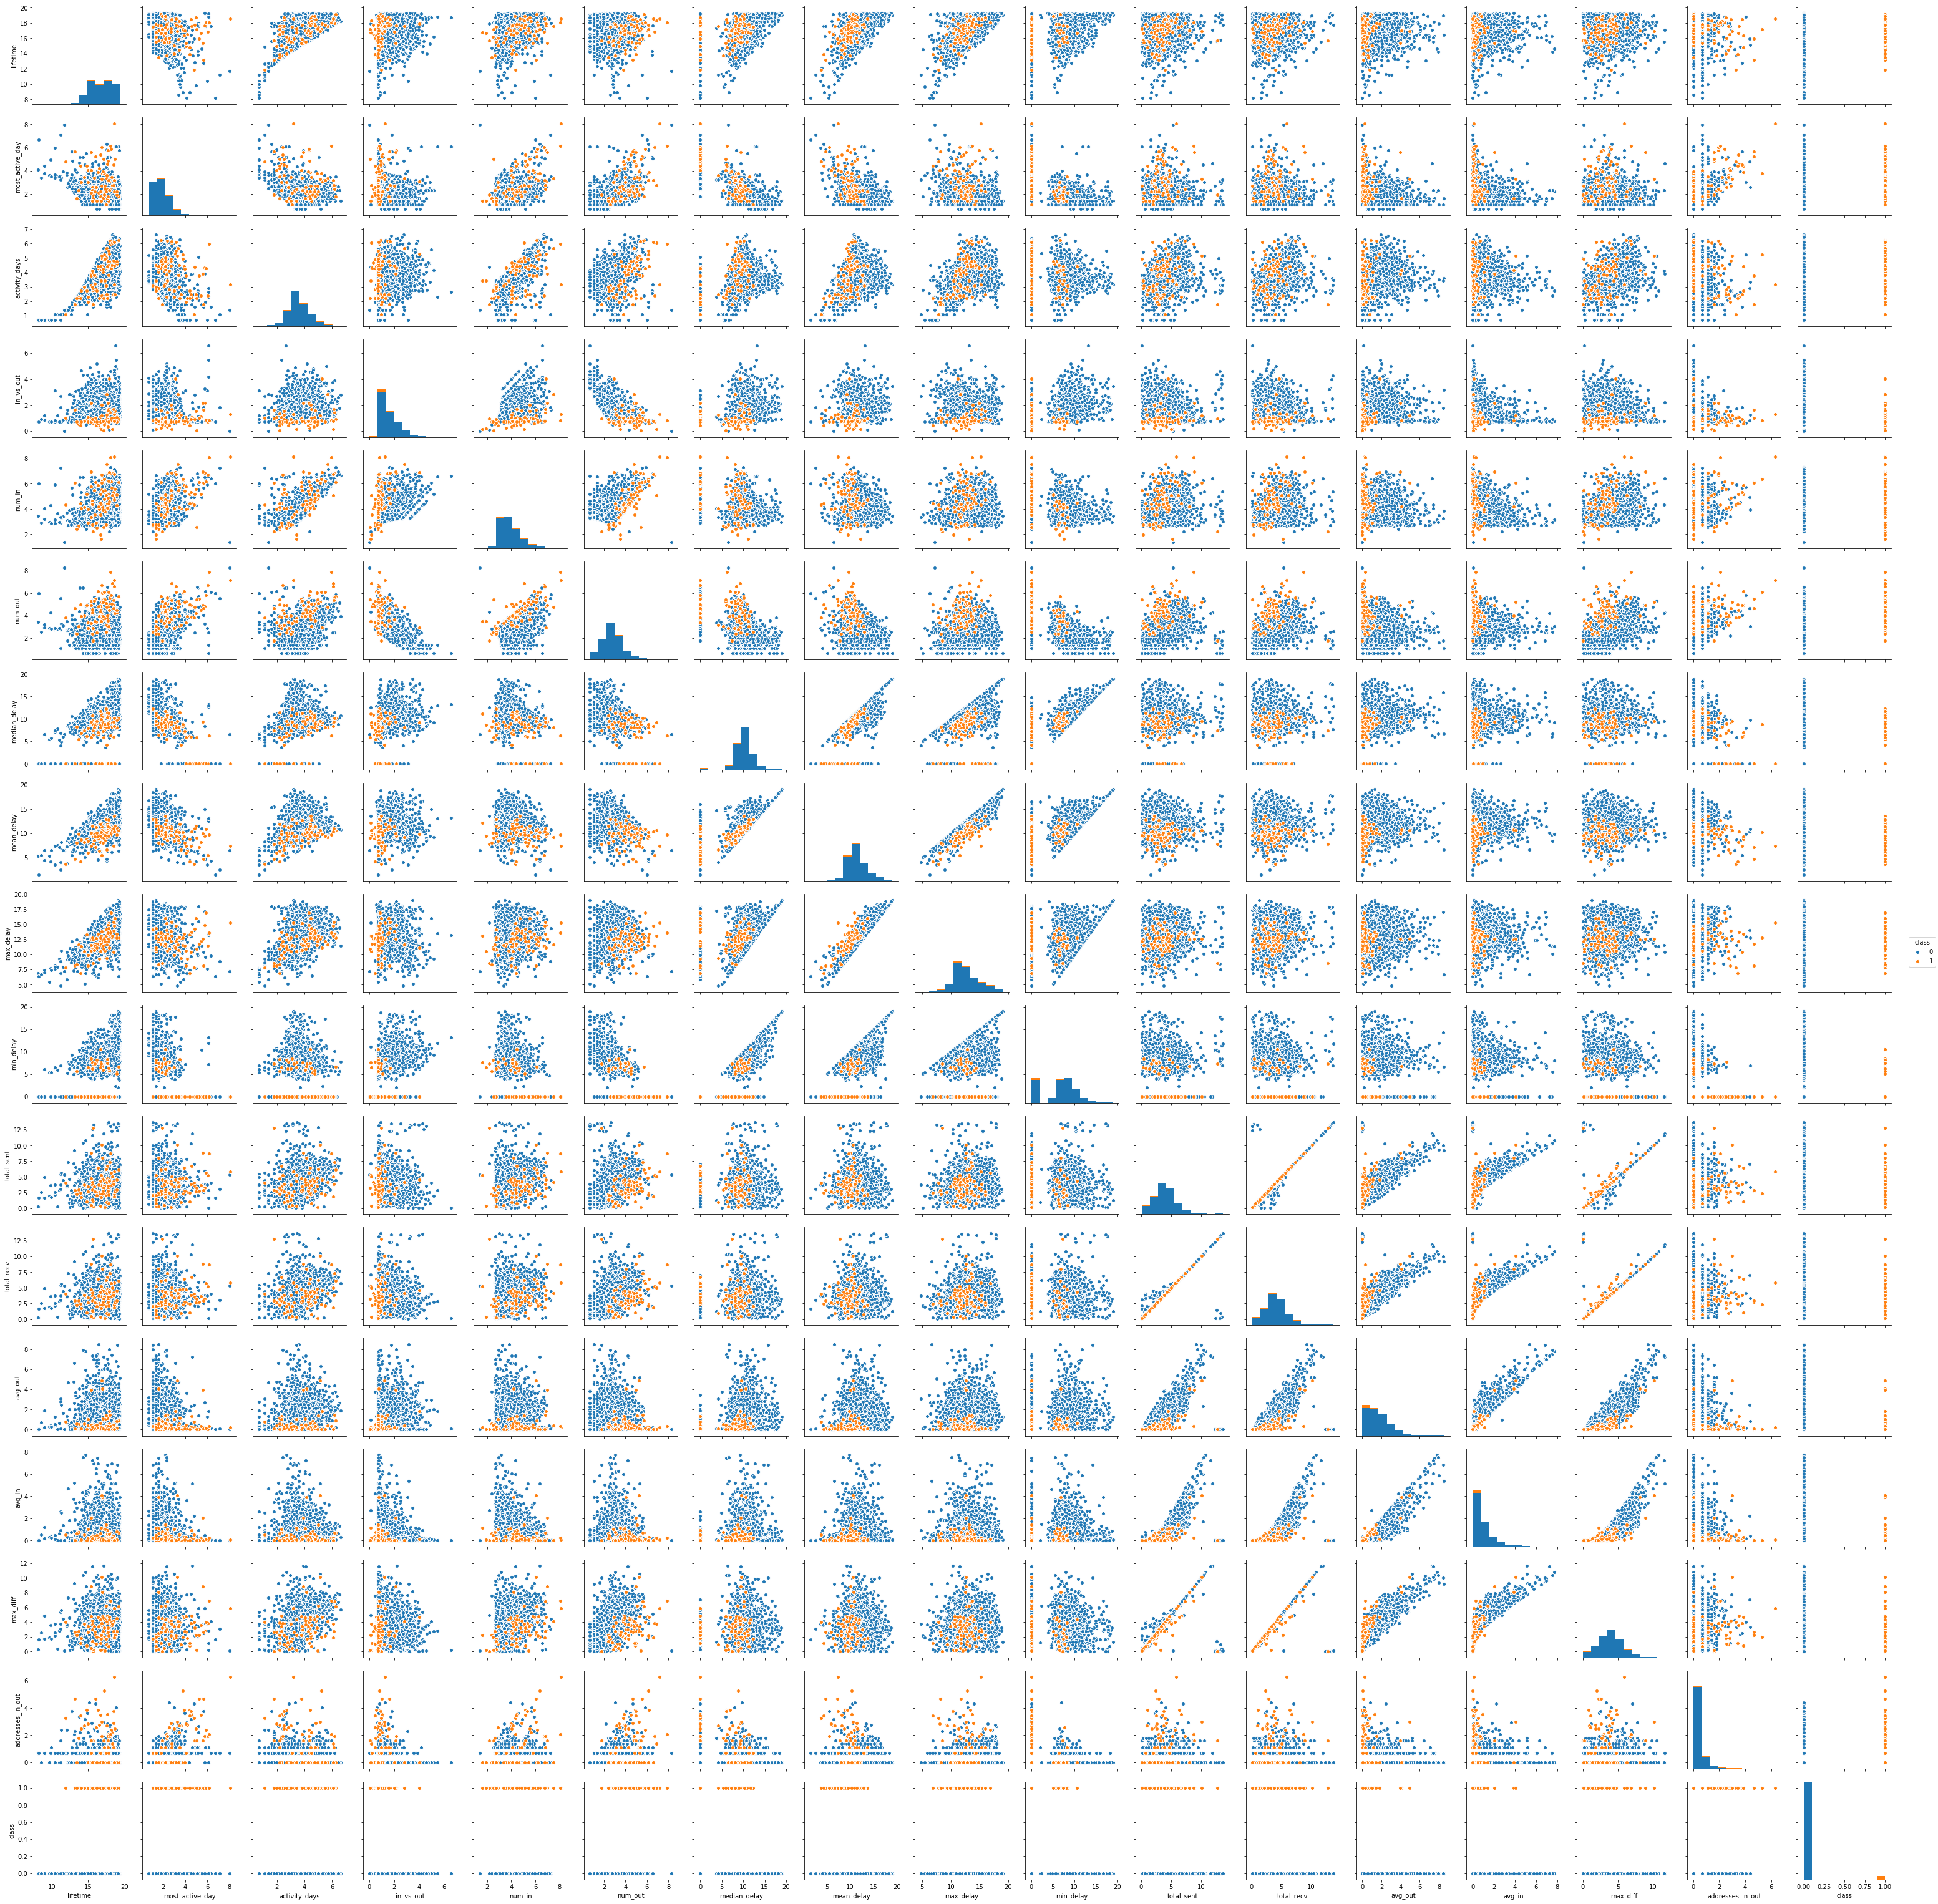

In [15]:
df = pd.concat([X, y], axis=1)
sns.pairplot(data=df, hue = 'class')

By comparing our feature matrix before and after transforming our feature values, we can see that this transformation provides more seperable data with respect to our two different classes. The matrix below derives the correlation coefficient for each cell in our feature matrix, shedding insight on which features may yield more/less predictive power.

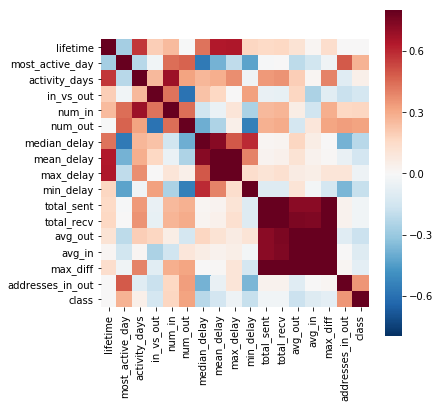

In [16]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corrmat, vmax = .8, vmin = -.8, cbar=True, annot=False, square=True, cmap = "RdBu_r");
plt.show()

In [17]:
X = df.iloc[:, df.columns != 'class']
y = df.iloc[:, df.columns == 'class']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)

In [18]:
scaled_features = StandardScaler().fit_transform(X.values)
scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
scaled_features_df.head()

lifetime  most_active_day  activity_days  in_vs_out    num_in   num_out  \
0 -1.316874        -0.169203      -0.980050   2.397798 -0.462283 -2.193259   
1  0.864577        -0.394334       1.047541  -0.266113  0.528274  0.620473   
2  1.372487         0.331466       1.406480   2.613283  1.525838 -1.051773   
3 -1.790216         0.331466      -1.425702   0.749164 -0.530497 -1.241210   
4 -1.958610         0.877041      -1.664375  -0.881333 -1.117047 -0.099724   

   median_delay  mean_delay  max_delay  min_delay  total_sent  total_recv  \
0     -2.006708   -2.909078  -3.398202  -0.309930   -2.013644   -1.006328   
1      0.054810   -0.158397  -0.085853   0.370021    0.473855    0.485509   
2     -0.431147   -1.070360  -1.637735   0.619251   -0.833727   -0.305365   
3     -0.619243   -1.090431  -1.214534  -1.513346    0.327880    0.334795   
4     -0.877041   -0.341842  -0.118649   0.010676    0.905718    0.931391   

    avg_out    avg_in  max_diff  addresses_in_out  
0 -1.226350 -0.750737 -1.009749         -0.377332  
1  0.070488  0.016406  0.555819         -0.377332  
2 -0.447531 -0.806465 -0.274142         -0.377332  
3  1.264644  0.469134  0.397656         -0.377332  
4  1.178082  1.872538  1.023737          0.804605

Now that we have a more balanced, standardized dataset, we can begin to handle issues with class imbalance, which poses significant challenges in the training and tuning of our model. The figure below shows the ratio of ponzi schemes to non ponzi. 

Ponzi instances:  77
Normal instances:  2222
-----
Ponzi TX %:  3.349282296650718
Normal TX %:  96.65071770334929


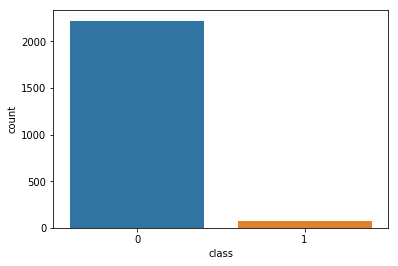

In [19]:
sns.countplot("class",data=df)

num_norm_tx = len(df[df["class"]==0])
num_ponzi_tx = len(df[df["class"]==1])

norm_tx_per = num_norm_tx/(num_norm_tx+num_ponzi_tx)
ponzi_tx_per = num_ponzi_tx/(num_norm_tx+num_ponzi_tx)

print("Ponzi instances: ", num_ponzi_tx)
print("Normal instances: ", num_norm_tx)
print("-----")
print("Ponzi TX %: ", num_ponzi_tx/(num_norm_tx+num_ponzi_tx)*100)
print("Normal TX %: ", num_norm_tx/(num_norm_tx+num_ponzi_tx)*100)

## III. Resampling Data

#### Performance Metrics
As seen above, our dataset is highly imbalanced with only a few instances of the minority class. This means we have to take extra consideration when specifying metrics used to determine the success of our model. A naive approach would find a consistently high level of accuracy, in which the model is always predicting the majority class. 

The confusion matrix below illustrates how these metrics are associated with classifying ponzi schemes.

<img src="./images/cfmatrix.png" width="400" align="left" />
<br>
<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $TP = Correctly\space identified\space ponzi$ <br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $FP = Incorrectly\space identified\space non-ponzi\space as\space ponzi$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $FN = Incorrectly\space identified\space ponzi\space as\space non-ponzi$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $TN = Correctly\space identified\space non-ponzi$
<br>


<br><br> <br><br> 
[Img source](https://hub.packtpub.com/supervised-learning-classification-and-regression/)

$Accuracy = \frac{tp + tn}{tp + tn + fp + fn}$  &nbsp; &nbsp; $Precision = \frac{tp}{tp+fp}$ &nbsp; &nbsp; $Recall = \frac{tp}{tp+fn}$

Instead, we'll use recall as our metric for determining the performance of our model. Recall is best suited for situations where there is a high cost associated with false negative, or in this case, failing to identify a ponzi scheme.


#### Resampling Techniques

Imbalanced classes provide a variety of challenges when training a model. We can address class imbalance in the following ways:
* Under-sampling of majority class
* Over-sampling of minority class
* Extrapolate new instances of minority class
* Adjust the cost function, making misclassification of minority more important

The figure below gives a visual representation of different resampling techniques shape rebalance classes.

<img src="./images/resampling.png" />

While the process of balancing classes provides considerable advantages during training, these techniques, as with most, have a tradeoff. For example, if we were to use a basic technique of replicating minority instances using over-sampling, our model would become prone to overfitting. On the other hand, undersampling the majority class reduces the amount of information that can be used to train our model. Therefore, we must adjust and tune our model accordingly.

### Method I: Undersampling 

In [20]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

num_fraud = (y_train_us == 1).sum()
num_norm = (y_train_us == 0).sum()
num_total = y_train.sum()
print("Ponzi instances: ", num_fraud)
print("Normal instances: ", num_norm)
print("-----")
print("Resampled Ponzi TX %: ", num_fraud/(num_fraud+num_norm)*100)
print("Resampled Normal TX %: ", num_norm/(num_fraud+num_norm)*100)

Ponzi instances:  62
Normal instances:  62
-----
Resampled Ponzi TX %:  50.0
Resampled Normal TX %:  50.0


### Method II & III: Oversampling w/ SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) is a method that synthesizes new members of the minority class by extrapolating features based on prior minority class instances and its k nearest neighbors. In traditional methods of oversampling, instances of the minority class are duplicated which is prone to overfitting, whereas SMOTE rebalances our classes with artificially generated data that has been shown to suffer less from overfitting.

<img src="./images/smote.png" width="300" align="left" />
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>


The SMOTE algorithm first obtains the k-nearest neighbors of a sample of the minority class $x_o$, then randomly select a minority class sample amongst k neighbors $\bar{x_i}$. Using these two samples, the algorithm then generates a new instance by interpolating between the two:

$x_{new} = x_o + rand(0,1) \times (x_i - x_o) $

As a result, the new generated instances cause the classifier to expand the deicision region for the minority class. 

We could also extend SMOTE to nominal features using the value difference metric (VDM) to measure the distance between two feature values, where:

$V_n$ = feature value
<br>
$C_n$ = frequency of $V_n$
<br>
$C_{ni}$ = frequency of $V_n$ for class $i$

$\delta(V_1, V_2) = \sum\limits_{i=1}^n \left|\frac{C_{1i}}{C_1} - \frac{C_{2i}}{C_2}\right|^k $

Using VDM, we can then calculate the distance between two feature vectors: $r=1$ yields Manhattan distance, $r=2$ yields Euclidean distance:
<br>
$\Delta(X,Y) = w_xw_y \sum\limits_{i=1}^N \delta(x_i,y_i)^r$
<br><br>
[Image source](https://www.researchgate.net/publication/287601878_A_Novel_Boundary_Oversampling_Algorithm_Based_on_Neighborhood_Rough_Set_Model_NRSBoundary-SMOTE)
<br>
[SMOTE publication by Chawla et al.](https://jair.org/index.php/jair/article/view/10302/24590)

In [21]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_train_os, y_train_os = sm.fit_resample(X_train, y_train)

num_fraud = (y_train_os == 1).sum()
num_norm = (y_train_os == 0).sum()
num_total = y_train_os.sum()

print("Ponzi instances: ", num_fraud)
print("Normal instances: ", num_norm)
print("-----")
print("Resampled Ponzi TX %: ", num_fraud/(num_fraud+num_norm)*100)
print("Resampled Normal TX %: ", num_norm/(num_fraud+num_norm)*100)

Ponzi instances:  1777
Normal instances:  1777
-----
Resampled Ponzi TX %:  50.0
Resampled Normal TX %:  50.0


### Comparing Resampling Techniques using Logistic Regression

To get a sense of how effective resampling really is, we can take a basic linear regression model and compare the perfomance on our standard, undersampled, and oversampled dataset. We will define a robust function allows us to test individual models on different sampling techinques, and then visualize its performance using the confusion matrix and the precision-recall curve. Generally speaking, the higher the area under the PRC, the better overall performance of the model.

In [22]:
def modelReport(name, sampling, model,X_train,X_test,y_train,y_test,isTuned, isEnsemble):   
    if(not isTuned): #If the model is not already tuned, we need to fit our model
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    if(isEnsemble): 
        y_score = model.predict_proba(X_test)[:,1] #predict_proba gives us a probability matrix for our classes
    else:
        y_score = model.decision_function(X_test)
    
    print("\n----------- " + name + " w/ " + sampling + " -----------")
    
    #we'll use a confusion matrix to visualize how well each model performs
    fig= plt.figure(figsize=(6,3))
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    sns.heatmap(confusion_matrix(y_test,y_pred),cmap="RdBu_r",annot=True,linewidths=0.5,fmt='g')#
    plt.show()
    
    print('Recall:   ',recall_score(y_test,y_pred))
    print('Precision:',precision_score(y_test,y_pred))
    print('AUC:      ',average_precision_score(y_test,y_score))
    
    #sklearn comes with some nifty prebuilt functions for getting the recall and precision of our model
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    
    #we can plot the PRC curve to view overall model performance
    plt.step(recall, precision, alpha=0.6, color='b', where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0, 1.05])
    plt.xlim([0, 1])
    plt.title('Precision-Recall curve')
    plt.show()
    
    #classification report is a package in sklearn that gives a nice print out of metrics for each class
    print(classification_report(y_test,y_pred))
    
    return([name, sampling, '{0:.2g}'.format(recall_score(y_test,y_pred)), '{0:.2g}'.format(average_precision_score(y_test,y_score))])

### Linear regression without resampling
As we might have expected, using a dataset with no form of rebalancing yields relatively low performance.

To reiterate the importance of metrics, this model has an accuracy of over 90%!! However, we now know that high accuracy in imbalanced datasets is smoke and mirrors. Our recall, on the other hand, is an abysmal 3%. Let's see how resampling techniques affects our recall.


----------- LR w/ No sampling -----------


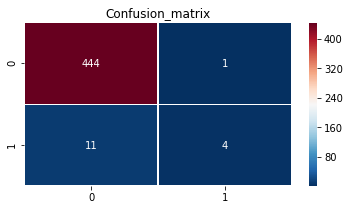

Recall:    0.26666666666666666
Precision: 0.8
AUC:       0.5896938318608799


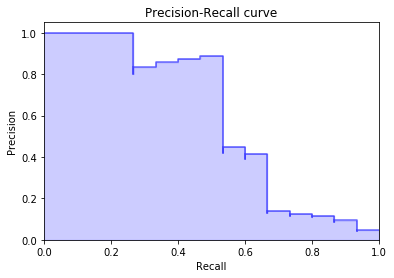

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       445
           1       0.80      0.27      0.40        15

   micro avg       0.97      0.97      0.97       460
   macro avg       0.89      0.63      0.69       460
weighted avg       0.97      0.97      0.97       460



['LR', 'No sampling', '0.27', '0.59']

In [23]:
baseModel = LogisticRegression()
modelReport("LR", "No sampling", baseModel, X_train,X_test,y_train,y_test, isTuned = False, isEnsemble = False)

### Logistic regression w/ Undersampling
Even with a straightforward random undersampling, we see an astronomical improvement in our level of recall. We were able to classify most ponzi schemes. On the other hand, our model incorrectly classified a high amount of instances as ponzi schemes.


----------- LR w/ Undersampling -----------


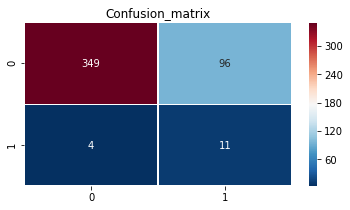

Recall:    0.7333333333333333
Precision: 0.102803738317757
AUC:       0.5696201136878373


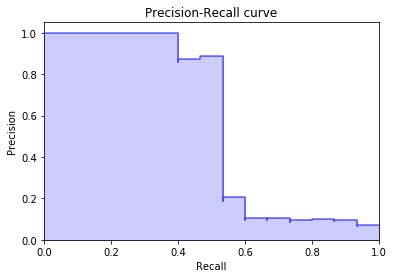

              precision    recall  f1-score   support

           0       0.99      0.78      0.87       445
           1       0.10      0.73      0.18        15

   micro avg       0.78      0.78      0.78       460
   macro avg       0.55      0.76      0.53       460
weighted avg       0.96      0.78      0.85       460



['LR', 'Undersampling', '0.73', '0.57']

In [24]:
us_model = LogisticRegression()
modelReport("LR", "Undersampling", us_model, X_train_us, X_test, y_train_us, y_test, isTuned = False, isEnsemble = False)

### Logistic regression w/ SMOTE oversampling
Oversampling gives us much of the same, a higher level of recall at the expense of misclassifying a large amount of non-ponzi schemes. It's pretty clear that resampling our dataset will provides substantial improvement in the training of our model. In the next section we will examine the effectiveness of different models on resampled datasets.


----------- LR w/ SMOTE Oversampling -----------


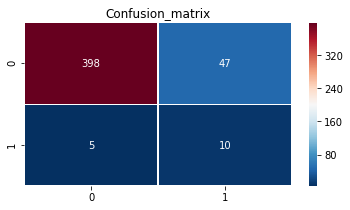

Recall:    0.6666666666666666
Precision: 0.17543859649122806
AUC:       0.5863511720527658


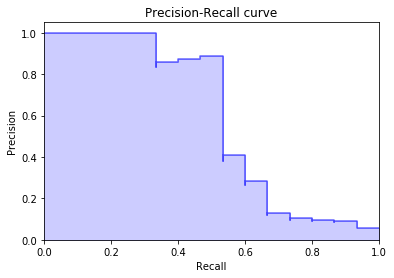

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       445
           1       0.18      0.67      0.28        15

   micro avg       0.89      0.89      0.89       460
   macro avg       0.58      0.78      0.61       460
weighted avg       0.96      0.89      0.92       460



['LR', 'SMOTE Oversampling', '0.67', '0.59']

In [25]:
os_model = LogisticRegression()
modelReport("LR", "SMOTE Oversampling",os_model, X_train_os, X_test, y_train_os, y_test, isTuned = False, isEnsemble = False)

## IV. Model Selection

Now that we've demonstrated the effectiveness of resampling, we can work with different models and sampling technique combinations to find the best performance for this classification task.


#### Models
* LR - Logistic Regression
* SVM - Support Vector Machine
* ADA - ADA Boost Classifier
* RF - Random Forest Classifier
* GB - Gradient Boosting Classifier

#### Resampling Methods
* RUS - Random Undersampling
* NM - Near Miss
* CC - ClusterCentroids
* ROS - Random Over Sampling
* SMOTE - SMOTE
* SNN - SMOTENN
* STK - SMOTETOMEK



To streamline things, we'll keep a list of our models and resampling methods:

In [26]:
models = []
models.append(['LR',LogisticRegression(random_state=2),False]) #We've added a boolean for handling ensembles when it comes time to fit
models.append(['SVM',SVC(random_state=2,gamma='scale'),False])
models.append(['ADA',AdaBoostClassifier(random_state=2),True])
models.append(['QDA',QuadraticDiscriminantAnalysis(),False])
models.append(['RF', RandomForestClassifier(random_state=2,n_estimators=100),True])
models.append(['GB', GradientBoostingClassifier(random_state=2),True])

Similar to before, we'll use the imblearn package to transform our dataset using various resampling techniques, each offering their own tradeoffs, which we'll investigate.

In [27]:
def resample(name,method,X_train,y_train):
    X__train_resampled, y__train_resampled = method.fit_sample(X_train,y_train) 
    
    return [name, pd.DataFrame(X__train_resampled), pd.DataFrame(y__train_resampled)]

In [28]:
datasets = []
datasets.append(["No sampling", X_train, y_train])
datasets.append(resample("RUS",RandomUnderSampler(),X_train,y_train))
datasets.append(resample("NM",NearMiss(n_jobs=-1),X_train,y_train))
datasets.append(resample("CC",ClusterCentroids(n_jobs=-1),X_train,y_train))
datasets.append(resample("ROS",RandomOverSampler(),X_train,y_train))
datasets.append(resample("SMOTE",SMOTE(n_jobs=-1),X_train,y_train))
datasets.append(resample("SNN",SMOTEENN(),X_train,y_train))
datasets.append(resample("STK",SMOTETomek(),X_train,y_train))

We'll keep track of scores for recall and AUC for our PRC curve to get a sense of how well each model/sampling technique performs. Using our modelReport function we defined earlier, we'll get a detailed report for the performance of each model. Having a scroll through the confusion matrices, we can see that some definitely perform better than others. 


----------- LR w/ No sampling -----------


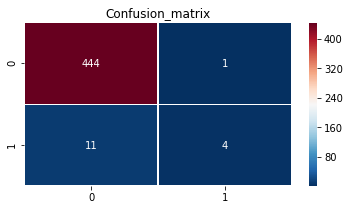

Recall:    0.26666666666666666
Precision: 0.8
AUC:       0.5896938318608799


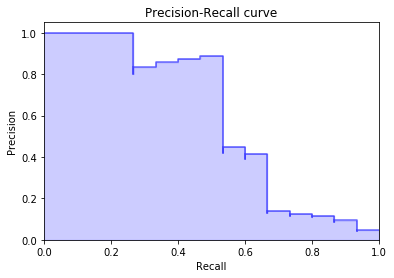

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       445
           1       0.80      0.27      0.40        15

   micro avg       0.97      0.97      0.97       460
   macro avg       0.89      0.63      0.69       460
weighted avg       0.97      0.97      0.97       460


----------- LR w/ RUS -----------


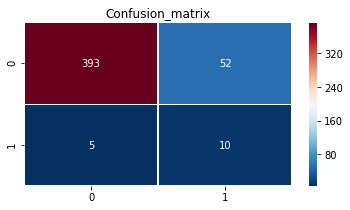

Recall:    0.6666666666666666
Precision: 0.16129032258064516
AUC:       0.5405560694429329


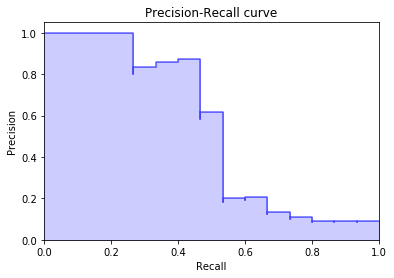

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       445
           1       0.16      0.67      0.26        15

   micro avg       0.88      0.88      0.88       460
   macro avg       0.57      0.77      0.60       460
weighted avg       0.96      0.88      0.91       460


----------- LR w/ NM -----------


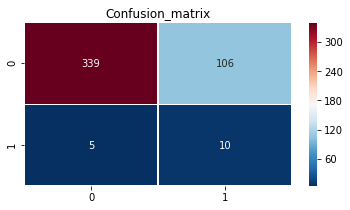

Recall:    0.6666666666666666
Precision: 0.08620689655172414
AUC:       0.23503141488667467


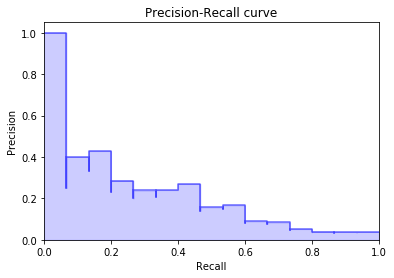

              precision    recall  f1-score   support

           0       0.99      0.76      0.86       445
           1       0.09      0.67      0.15        15

   micro avg       0.76      0.76      0.76       460
   macro avg       0.54      0.71      0.51       460
weighted avg       0.96      0.76      0.84       460


----------- LR w/ CC -----------


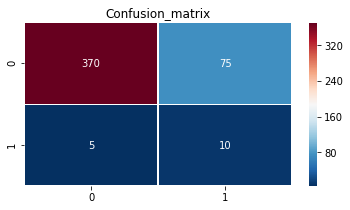

Recall:    0.6666666666666666
Precision: 0.11764705882352941
AUC:       0.5299903083194848


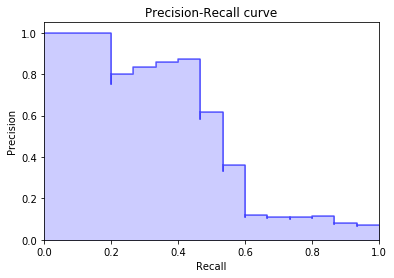

              precision    recall  f1-score   support

           0       0.99      0.83      0.90       445
           1       0.12      0.67      0.20        15

   micro avg       0.83      0.83      0.83       460
   macro avg       0.55      0.75      0.55       460
weighted avg       0.96      0.83      0.88       460


----------- LR w/ ROS -----------


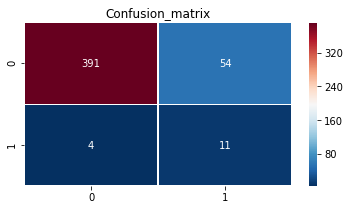

Recall:    0.7333333333333333
Precision: 0.16923076923076924
AUC:       0.5711493238410844


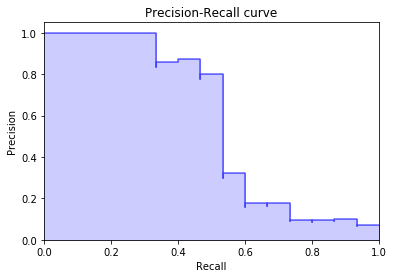

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       445
           1       0.17      0.73      0.28        15

   micro avg       0.87      0.87      0.87       460
   macro avg       0.58      0.81      0.60       460
weighted avg       0.96      0.87      0.91       460


----------- LR w/ SMOTE -----------


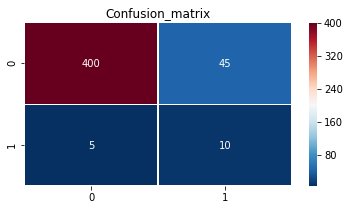

Recall:    0.6666666666666666
Precision: 0.18181818181818182
AUC:       0.5795348842766623


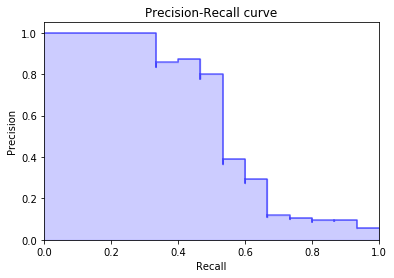

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       445
           1       0.18      0.67      0.29        15

   micro avg       0.89      0.89      0.89       460
   macro avg       0.58      0.78      0.61       460
weighted avg       0.96      0.89      0.92       460


----------- LR w/ SNN -----------


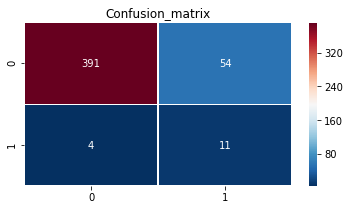

Recall:    0.7333333333333333
Precision: 0.16923076923076924
AUC:       0.5996073472666608


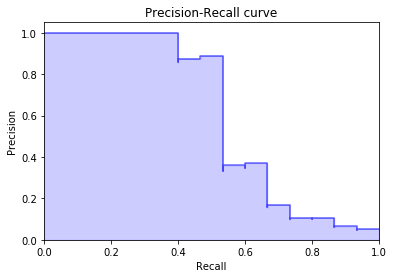

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       445
           1       0.17      0.73      0.28        15

   micro avg       0.87      0.87      0.87       460
   macro avg       0.58      0.81      0.60       460
weighted avg       0.96      0.87      0.91       460


----------- LR w/ STK -----------


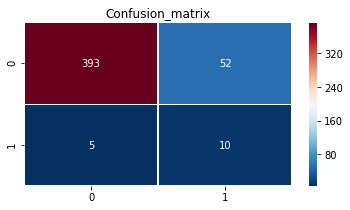

Recall:    0.6666666666666666
Precision: 0.16129032258064516
AUC:       0.5852878456996845


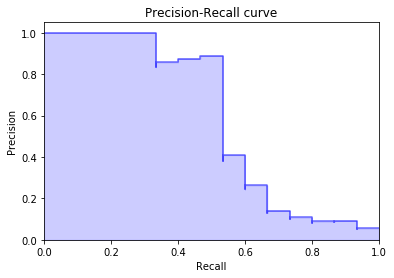

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       445
           1       0.16      0.67      0.26        15

   micro avg       0.88      0.88      0.88       460
   macro avg       0.57      0.77      0.60       460
weighted avg       0.96      0.88      0.91       460


----------- SVM w/ No sampling -----------


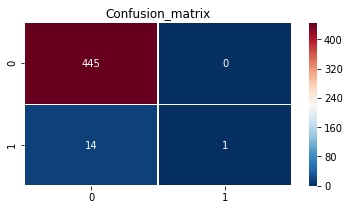

Recall:    0.06666666666666667
Precision: 1.0
AUC:       0.5428179614050868


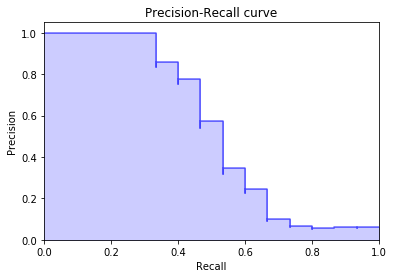

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       445
           1       1.00      0.07      0.12        15

   micro avg       0.97      0.97      0.97       460
   macro avg       0.98      0.53      0.55       460
weighted avg       0.97      0.97      0.96       460


----------- SVM w/ RUS -----------


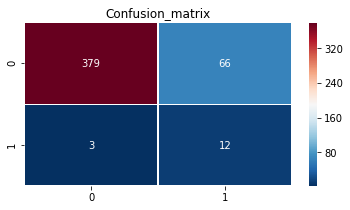

Recall:    0.8
Precision: 0.15384615384615385
AUC:       0.560628894882398


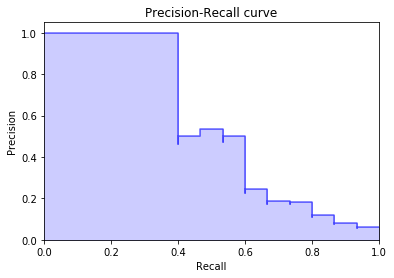

              precision    recall  f1-score   support

           0       0.99      0.85      0.92       445
           1       0.15      0.80      0.26        15

   micro avg       0.85      0.85      0.85       460
   macro avg       0.57      0.83      0.59       460
weighted avg       0.96      0.85      0.90       460


----------- SVM w/ NM -----------


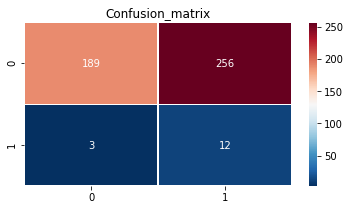

Recall:    0.8
Precision: 0.04477611940298507
AUC:       0.17067437558904786


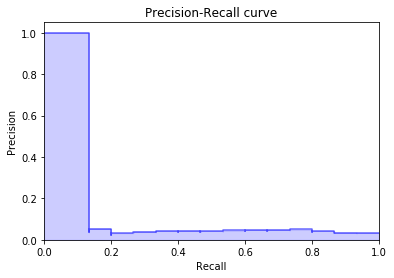

              precision    recall  f1-score   support

           0       0.98      0.42      0.59       445
           1       0.04      0.80      0.08        15

   micro avg       0.44      0.44      0.44       460
   macro avg       0.51      0.61      0.34       460
weighted avg       0.95      0.44      0.58       460


----------- SVM w/ CC -----------


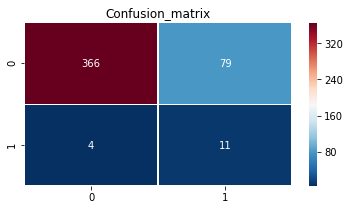

Recall:    0.7333333333333333
Precision: 0.12222222222222222
AUC:       0.5801815649641736


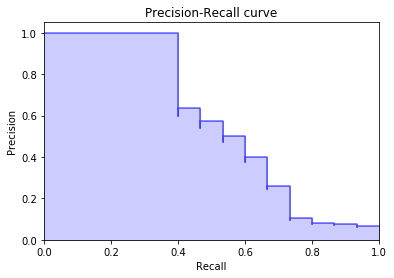

              precision    recall  f1-score   support

           0       0.99      0.82      0.90       445
           1       0.12      0.73      0.21        15

   micro avg       0.82      0.82      0.82       460
   macro avg       0.56      0.78      0.55       460
weighted avg       0.96      0.82      0.88       460


----------- SVM w/ ROS -----------


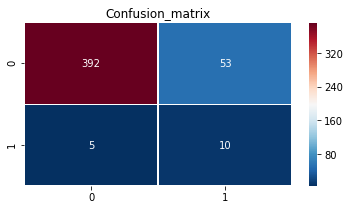

Recall:    0.6666666666666666
Precision: 0.15873015873015872
AUC:       0.4936520340559823


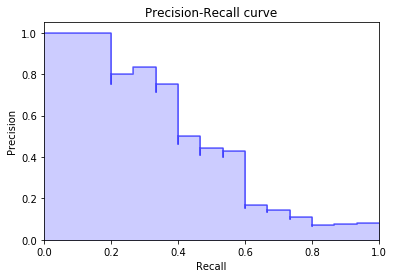

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       445
           1       0.16      0.67      0.26        15

   micro avg       0.87      0.87      0.87       460
   macro avg       0.57      0.77      0.59       460
weighted avg       0.96      0.87      0.91       460


----------- SVM w/ SMOTE -----------


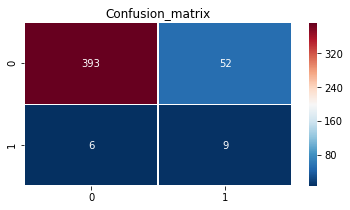

Recall:    0.6
Precision: 0.14754098360655737
AUC:       0.5108724641998006


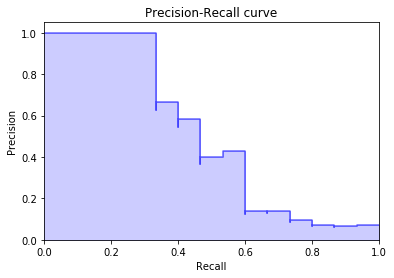

              precision    recall  f1-score   support

           0       0.98      0.88      0.93       445
           1       0.15      0.60      0.24        15

   micro avg       0.87      0.87      0.87       460
   macro avg       0.57      0.74      0.58       460
weighted avg       0.96      0.87      0.91       460


----------- SVM w/ SNN -----------


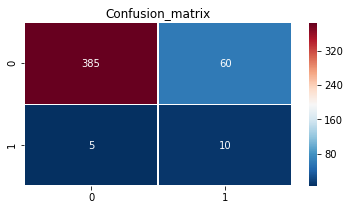

Recall:    0.6666666666666666
Precision: 0.14285714285714285
AUC:       0.5066072442324117


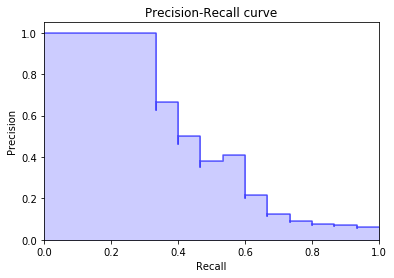

              precision    recall  f1-score   support

           0       0.99      0.87      0.92       445
           1       0.14      0.67      0.24        15

   micro avg       0.86      0.86      0.86       460
   macro avg       0.57      0.77      0.58       460
weighted avg       0.96      0.86      0.90       460


----------- SVM w/ STK -----------


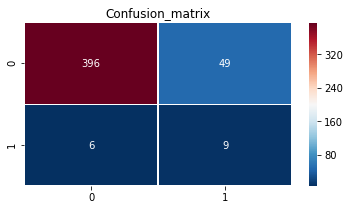

Recall:    0.6
Precision: 0.15517241379310345
AUC:       0.49696620589331364


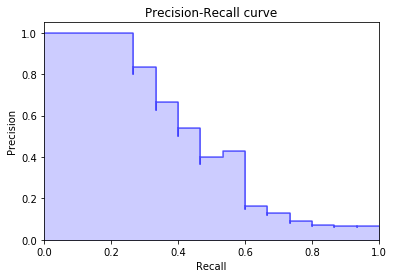

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       445
           1       0.16      0.60      0.25        15

   micro avg       0.88      0.88      0.88       460
   macro avg       0.57      0.74      0.59       460
weighted avg       0.96      0.88      0.91       460


----------- ADA w/ No sampling -----------


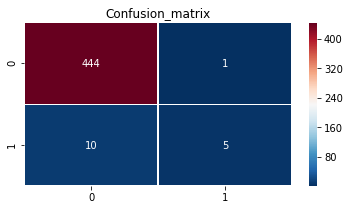

Recall:    0.3333333333333333
Precision: 0.8333333333333334
AUC:       0.5188246557790531


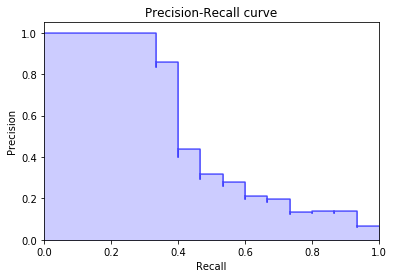

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       445
           1       0.83      0.33      0.48        15

   micro avg       0.98      0.98      0.98       460
   macro avg       0.91      0.67      0.73       460
weighted avg       0.97      0.98      0.97       460


----------- ADA w/ RUS -----------


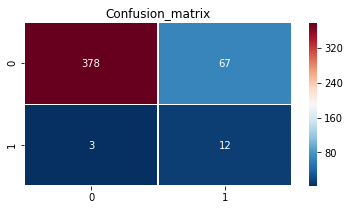

Recall:    0.8
Precision: 0.1518987341772152
AUC:       0.5325794942970515


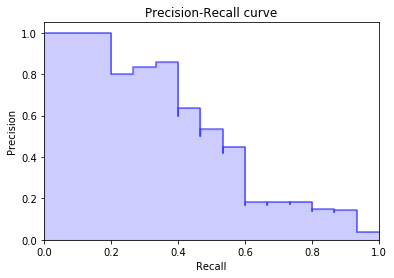

              precision    recall  f1-score   support

           0       0.99      0.85      0.92       445
           1       0.15      0.80      0.26        15

   micro avg       0.85      0.85      0.85       460
   macro avg       0.57      0.82      0.59       460
weighted avg       0.96      0.85      0.89       460


----------- ADA w/ NM -----------


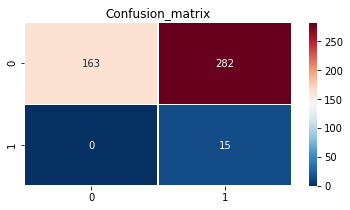

Recall:    1.0
Precision: 0.050505050505050504
AUC:       0.24684969825058142


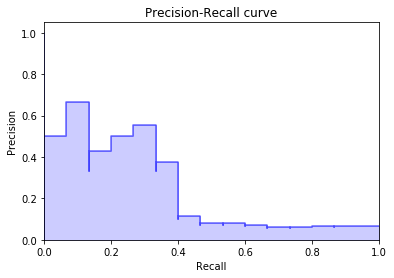

              precision    recall  f1-score   support

           0       1.00      0.37      0.54       445
           1       0.05      1.00      0.10        15

   micro avg       0.39      0.39      0.39       460
   macro avg       0.53      0.68      0.32       460
weighted avg       0.97      0.39      0.52       460


----------- ADA w/ CC -----------


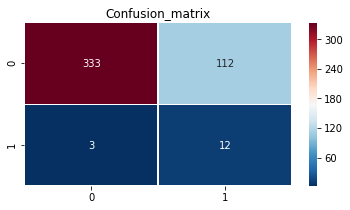

Recall:    0.8
Precision: 0.0967741935483871
AUC:       0.5250181373984868


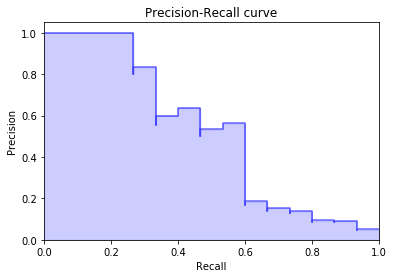

              precision    recall  f1-score   support

           0       0.99      0.75      0.85       445
           1       0.10      0.80      0.17        15

   micro avg       0.75      0.75      0.75       460
   macro avg       0.54      0.77      0.51       460
weighted avg       0.96      0.75      0.83       460


----------- ADA w/ ROS -----------


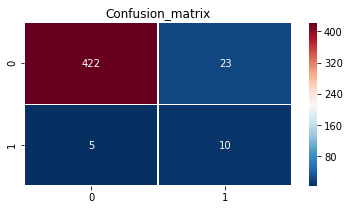

Recall:    0.6666666666666666
Precision: 0.30303030303030304
AUC:       0.5926344074147692


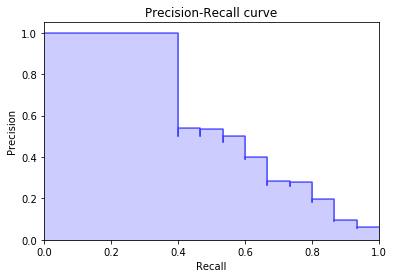

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       445
           1       0.30      0.67      0.42        15

   micro avg       0.94      0.94      0.94       460
   macro avg       0.65      0.81      0.69       460
weighted avg       0.97      0.94      0.95       460


----------- ADA w/ SMOTE -----------


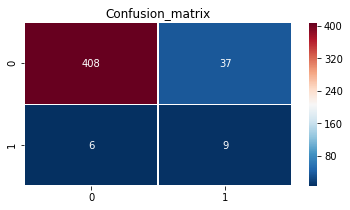

Recall:    0.6
Precision: 0.1956521739130435
AUC:       0.4900840818850729


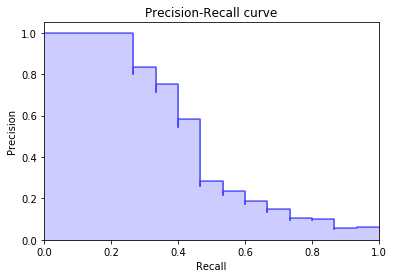

              precision    recall  f1-score   support

           0       0.99      0.92      0.95       445
           1       0.20      0.60      0.30        15

   micro avg       0.91      0.91      0.91       460
   macro avg       0.59      0.76      0.62       460
weighted avg       0.96      0.91      0.93       460


----------- ADA w/ SNN -----------


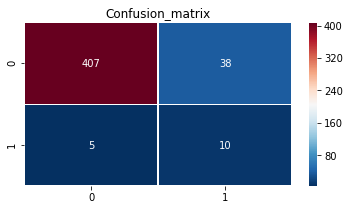

Recall:    0.6666666666666666
Precision: 0.20833333333333334
AUC:       0.5357574525150045


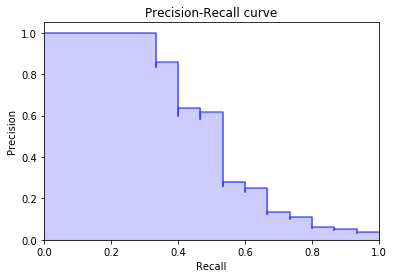

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       445
           1       0.21      0.67      0.32        15

   micro avg       0.91      0.91      0.91       460
   macro avg       0.60      0.79      0.63       460
weighted avg       0.96      0.91      0.93       460


----------- ADA w/ STK -----------


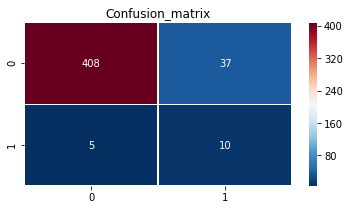

Recall:    0.6666666666666666
Precision: 0.2127659574468085
AUC:       0.5429494462442445


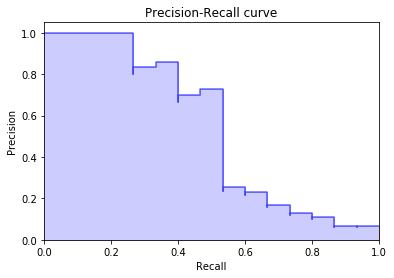

              precision    recall  f1-score   support

           0       0.99      0.92      0.95       445
           1       0.21      0.67      0.32        15

   micro avg       0.91      0.91      0.91       460
   macro avg       0.60      0.79      0.64       460
weighted avg       0.96      0.91      0.93       460


----------- QDA w/ No sampling -----------


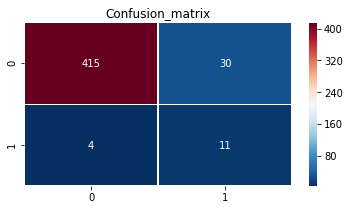

Recall:    0.7333333333333333
Precision: 0.2682926829268293
AUC:       0.5103094377261395


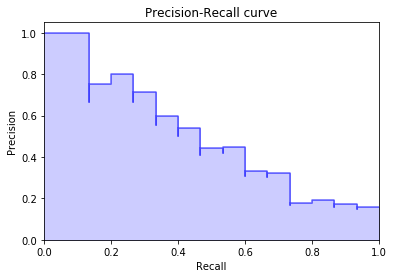

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       445
           1       0.27      0.73      0.39        15

   micro avg       0.93      0.93      0.93       460
   macro avg       0.63      0.83      0.68       460
weighted avg       0.97      0.93      0.94       460


----------- QDA w/ RUS -----------


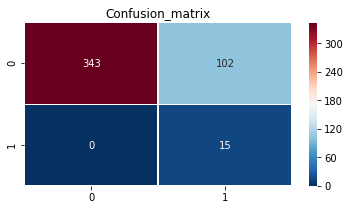

Recall:    1.0
Precision: 0.1282051282051282
AUC:       0.5660975049030385


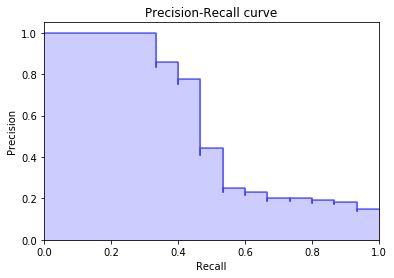

              precision    recall  f1-score   support

           0       1.00      0.77      0.87       445
           1       0.13      1.00      0.23        15

   micro avg       0.78      0.78      0.78       460
   macro avg       0.56      0.89      0.55       460
weighted avg       0.97      0.78      0.85       460


----------- QDA w/ NM -----------


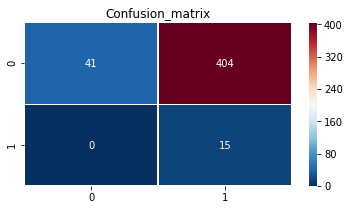

Recall:    1.0
Precision: 0.03579952267303103
AUC:       0.3602547934567806


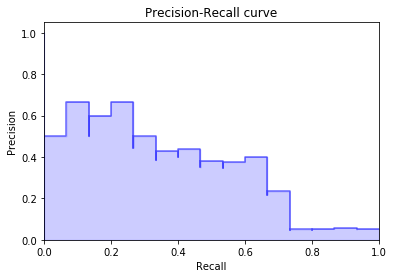

              precision    recall  f1-score   support

           0       1.00      0.09      0.17       445
           1       0.04      1.00      0.07        15

   micro avg       0.12      0.12      0.12       460
   macro avg       0.52      0.55      0.12       460
weighted avg       0.97      0.12      0.17       460


----------- QDA w/ CC -----------


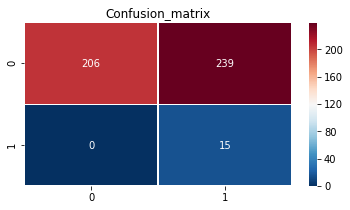

Recall:    1.0
Precision: 0.05905511811023622
AUC:       0.4822380522722203


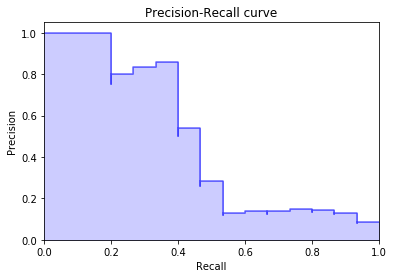

              precision    recall  f1-score   support

           0       1.00      0.46      0.63       445
           1       0.06      1.00      0.11        15

   micro avg       0.48      0.48      0.48       460
   macro avg       0.53      0.73      0.37       460
weighted avg       0.97      0.48      0.62       460


----------- QDA w/ ROS -----------


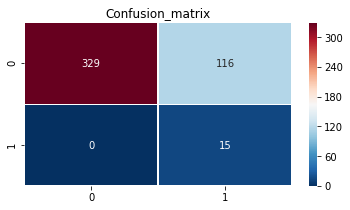

Recall:    1.0
Precision: 0.11450381679389313
AUC:       0.51413672541819


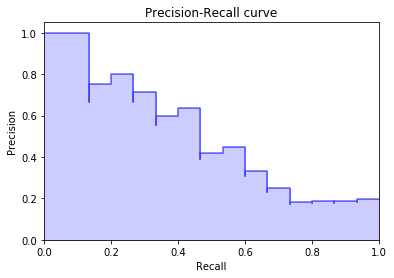

              precision    recall  f1-score   support

           0       1.00      0.74      0.85       445
           1       0.11      1.00      0.21        15

   micro avg       0.75      0.75      0.75       460
   macro avg       0.56      0.87      0.53       460
weighted avg       0.97      0.75      0.83       460


----------- QDA w/ SMOTE -----------


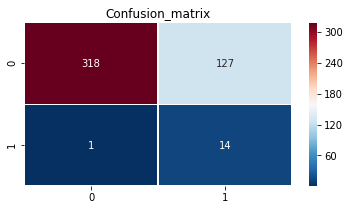

Recall:    0.9333333333333333
Precision: 0.09929078014184398
AUC:       0.5586759109829373


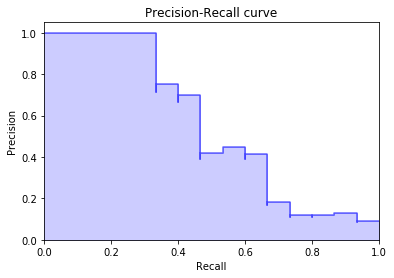

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       445
           1       0.10      0.93      0.18        15

   micro avg       0.72      0.72      0.72       460
   macro avg       0.55      0.82      0.51       460
weighted avg       0.97      0.72      0.81       460


----------- QDA w/ SNN -----------


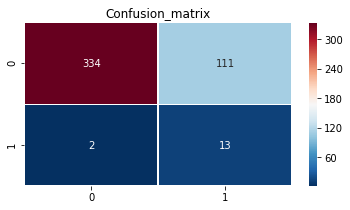

Recall:    0.8666666666666667
Precision: 0.10483870967741936
AUC:       0.5471095238292926


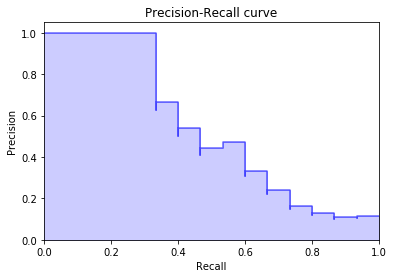

              precision    recall  f1-score   support

           0       0.99      0.75      0.86       445
           1       0.10      0.87      0.19        15

   micro avg       0.75      0.75      0.75       460
   macro avg       0.55      0.81      0.52       460
weighted avg       0.97      0.75      0.83       460


----------- QDA w/ STK -----------


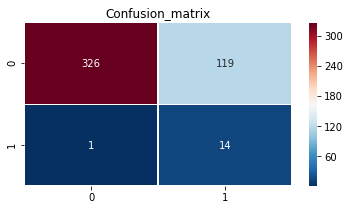

Recall:    0.9333333333333333
Precision: 0.10526315789473684
AUC:       0.5641884452733901


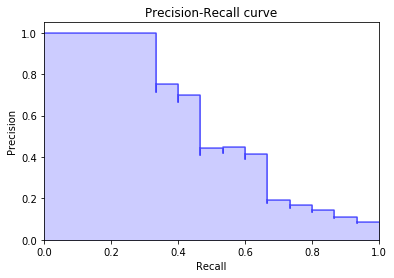

              precision    recall  f1-score   support

           0       1.00      0.73      0.84       445
           1       0.11      0.93      0.19        15

   micro avg       0.74      0.74      0.74       460
   macro avg       0.55      0.83      0.52       460
weighted avg       0.97      0.74      0.82       460


----------- RF w/ No sampling -----------


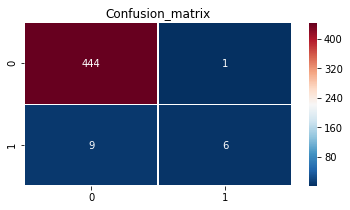

Recall:    0.4
Precision: 0.8571428571428571
AUC:       0.6775802981359771


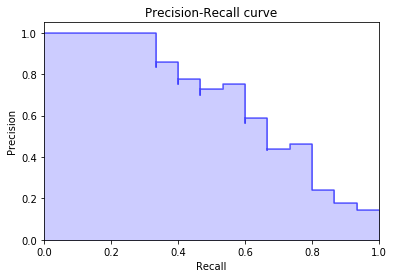

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       445
           1       0.86      0.40      0.55        15

   micro avg       0.98      0.98      0.98       460
   macro avg       0.92      0.70      0.77       460
weighted avg       0.98      0.98      0.97       460


----------- RF w/ RUS -----------


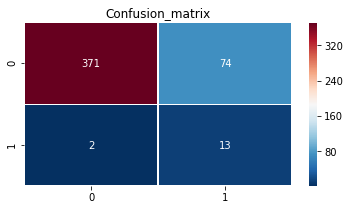

Recall:    0.8666666666666667
Precision: 0.14942528735632185
AUC:       0.45297367765838026


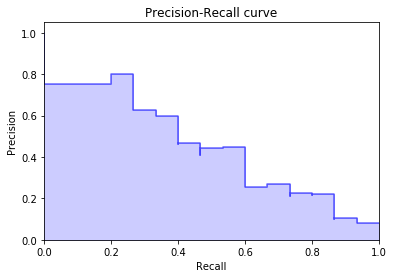

              precision    recall  f1-score   support

           0       0.99      0.83      0.91       445
           1       0.15      0.87      0.25        15

   micro avg       0.83      0.83      0.83       460
   macro avg       0.57      0.85      0.58       460
weighted avg       0.97      0.83      0.89       460


----------- RF w/ NM -----------


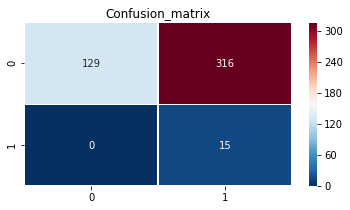

Recall:    1.0
Precision: 0.045317220543806644
AUC:       0.060899877155914946


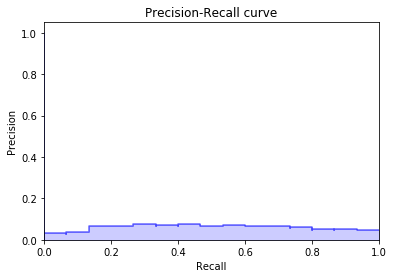

              precision    recall  f1-score   support

           0       1.00      0.29      0.45       445
           1       0.05      1.00      0.09        15

   micro avg       0.31      0.31      0.31       460
   macro avg       0.52      0.64      0.27       460
weighted avg       0.97      0.31      0.44       460


----------- RF w/ CC -----------


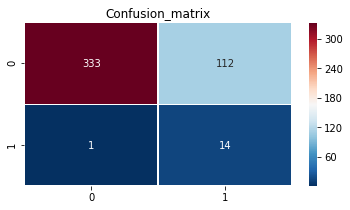

Recall:    0.9333333333333333
Precision: 0.1111111111111111
AUC:       0.4507970426149236


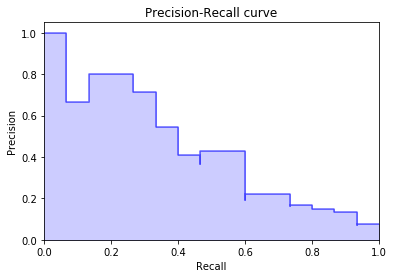

              precision    recall  f1-score   support

           0       1.00      0.75      0.85       445
           1       0.11      0.93      0.20        15

   micro avg       0.75      0.75      0.75       460
   macro avg       0.55      0.84      0.53       460
weighted avg       0.97      0.75      0.83       460


----------- RF w/ ROS -----------


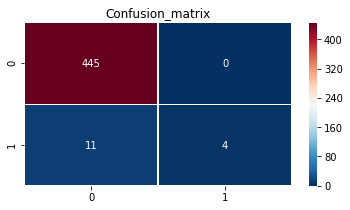

Recall:    0.26666666666666666
Precision: 1.0
AUC:       0.5643587176502554


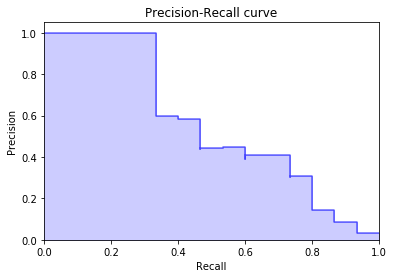

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       445
           1       1.00      0.27      0.42        15

   micro avg       0.98      0.98      0.98       460
   macro avg       0.99      0.63      0.70       460
weighted avg       0.98      0.98      0.97       460


----------- RF w/ SMOTE -----------


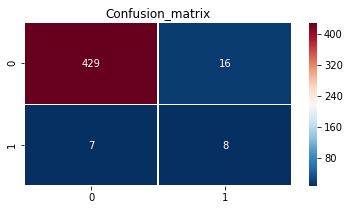

Recall:    0.5333333333333333
Precision: 0.3333333333333333
AUC:       0.4768520747483384


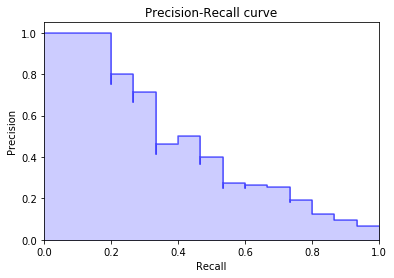

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       445
           1       0.33      0.53      0.41        15

   micro avg       0.95      0.95      0.95       460
   macro avg       0.66      0.75      0.69       460
weighted avg       0.96      0.95      0.96       460


----------- RF w/ SNN -----------


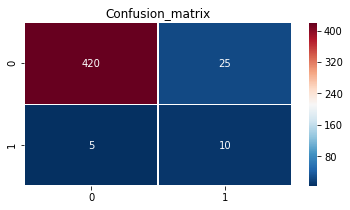

Recall:    0.6666666666666666
Precision: 0.2857142857142857
AUC:       0.4856350207862836


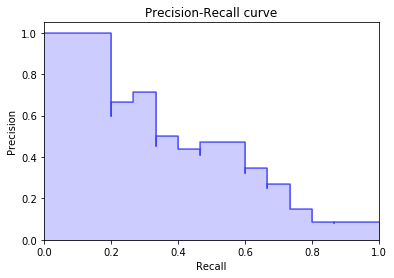

              precision    recall  f1-score   support

           0       0.99      0.94      0.97       445
           1       0.29      0.67      0.40        15

   micro avg       0.93      0.93      0.93       460
   macro avg       0.64      0.81      0.68       460
weighted avg       0.97      0.93      0.95       460


----------- RF w/ STK -----------


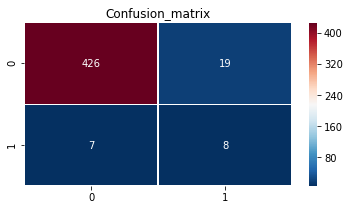

Recall:    0.5333333333333333
Precision: 0.2962962962962963
AUC:       0.49587119141233044


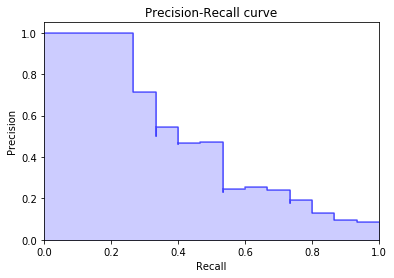

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       445
           1       0.30      0.53      0.38        15

   micro avg       0.94      0.94      0.94       460
   macro avg       0.64      0.75      0.68       460
weighted avg       0.96      0.94      0.95       460


----------- GB w/ No sampling -----------


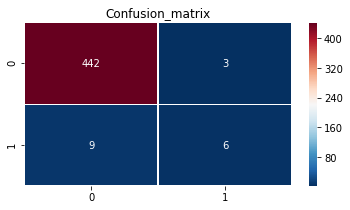

Recall:    0.4
Precision: 0.6666666666666666
AUC:       0.5968711212928207


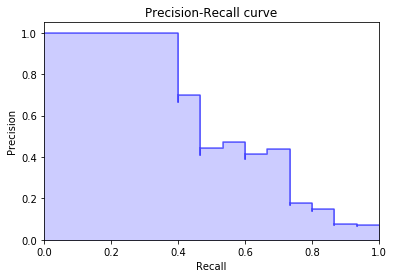

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       445
           1       0.67      0.40      0.50        15

   micro avg       0.97      0.97      0.97       460
   macro avg       0.82      0.70      0.74       460
weighted avg       0.97      0.97      0.97       460


----------- GB w/ RUS -----------


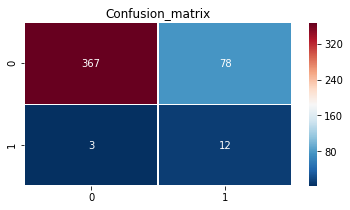

Recall:    0.8
Precision: 0.13333333333333333
AUC:       0.3837685982917399


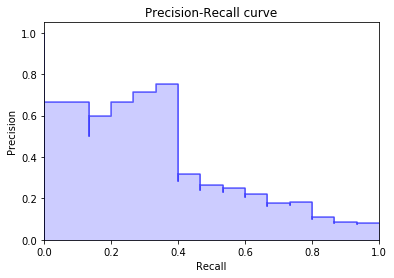

              precision    recall  f1-score   support

           0       0.99      0.82      0.90       445
           1       0.13      0.80      0.23        15

   micro avg       0.82      0.82      0.82       460
   macro avg       0.56      0.81      0.56       460
weighted avg       0.96      0.82      0.88       460


----------- GB w/ NM -----------


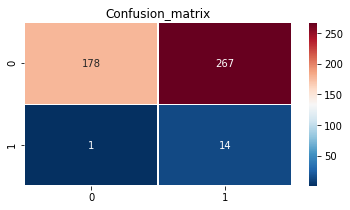

Recall:    0.9333333333333333
Precision: 0.0498220640569395
AUC:       0.25039157410101814


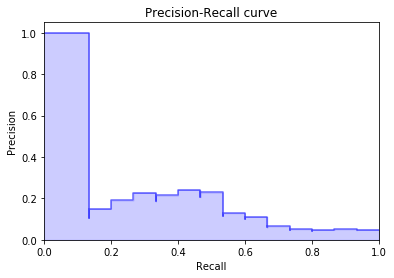

              precision    recall  f1-score   support

           0       0.99      0.40      0.57       445
           1       0.05      0.93      0.09        15

   micro avg       0.42      0.42      0.42       460
   macro avg       0.52      0.67      0.33       460
weighted avg       0.96      0.42      0.55       460


----------- GB w/ CC -----------


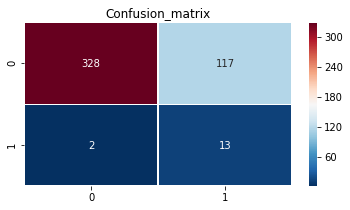

Recall:    0.8666666666666667
Precision: 0.1
AUC:       0.30073116118694215


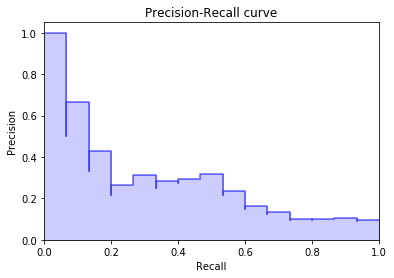

              precision    recall  f1-score   support

           0       0.99      0.74      0.85       445
           1       0.10      0.87      0.18        15

   micro avg       0.74      0.74      0.74       460
   macro avg       0.55      0.80      0.51       460
weighted avg       0.96      0.74      0.82       460


----------- GB w/ ROS -----------


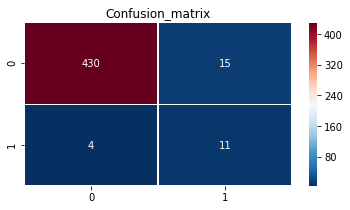

Recall:    0.7333333333333333
Precision: 0.4230769230769231
AUC:       0.6377759380747845


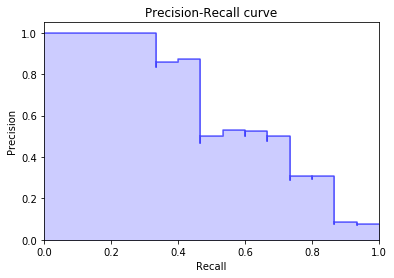

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       445
           1       0.42      0.73      0.54        15

   micro avg       0.96      0.96      0.96       460
   macro avg       0.71      0.85      0.76       460
weighted avg       0.97      0.96      0.96       460


----------- GB w/ SMOTE -----------


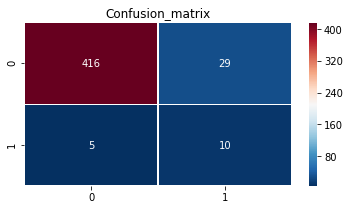

Recall:    0.6666666666666666
Precision: 0.2564102564102564
AUC:       0.542888157482816


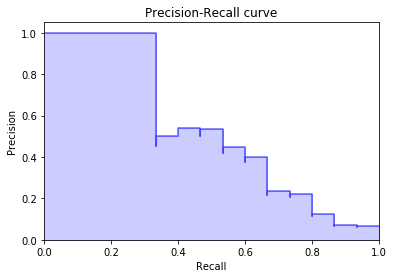

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       445
           1       0.26      0.67      0.37        15

   micro avg       0.93      0.93      0.93       460
   macro avg       0.62      0.80      0.67       460
weighted avg       0.96      0.93      0.94       460


----------- GB w/ SNN -----------


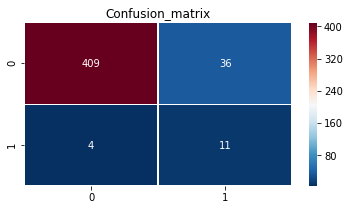

Recall:    0.7333333333333333
Precision: 0.23404255319148937
AUC:       0.5625270495551508


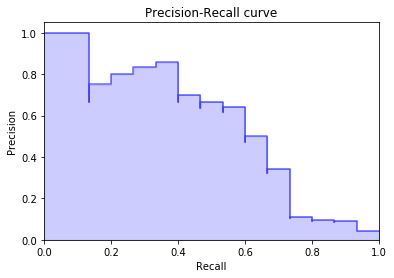

              precision    recall  f1-score   support

           0       0.99      0.92      0.95       445
           1       0.23      0.73      0.35        15

   micro avg       0.91      0.91      0.91       460
   macro avg       0.61      0.83      0.65       460
weighted avg       0.97      0.91      0.93       460


----------- GB w/ STK -----------


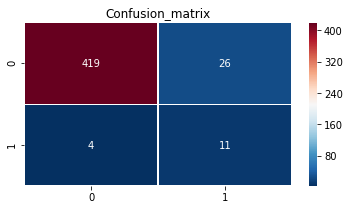

Recall:    0.7333333333333333
Precision: 0.2972972972972973
AUC:       0.5666772769743135


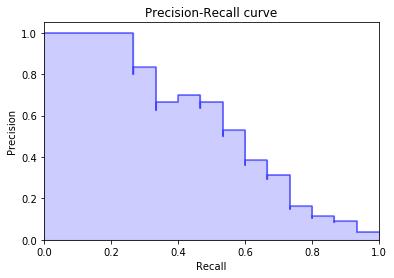

              precision    recall  f1-score   support

           0       0.99      0.94      0.97       445
           1       0.30      0.73      0.42        15

   micro avg       0.93      0.93      0.93       460
   macro avg       0.64      0.84      0.69       460
weighted avg       0.97      0.93      0.95       460



In [29]:
#lists to keep track of scoring
recall_scores = []
auc_scores = []

#we iterate through each type of model in our models list
for model in models:
    recall_scores.append([model[0]])
    auc_scores.append([model[0]])
    
    #then we iterate through each resampled dataset to generate a performance report for each model
    for dataset in datasets:
        scores = modelReport(model[0], dataset[0], model[1], dataset[1], X_test, dataset[2], y_test, False, model[2])
        recall_scores[-1].append(scores[2])
        auc_scores[-1].append(scores[3])

To give a better overview each model's performance, we can view our performance matrix for recall and AUC of our PRC. As you can see have a few instances of perfect recall! Which means our model was able to correctly classify every ponzi scheme. We also know that this may be due to overfitting, which we'll explore more in the following section.

Looking at some of the instances of high recall, we also see that the PRC AUC can be quite low, which indicates that the model generated high amount of false positives. In the context of bitcoin, this may not be the worst thing as it would give the FBI, or any kind of regulatory agency, a list of addresses for further inspection that would contain all actual ponzi schemes. 

We certainly dont want to make the FBI sift through hundreds of false positives, so we will tune our model using hyperparameters while checking for any overfitting.

In [30]:
print("Recall Scores:")
column_headers = ["None", "RUS", "NM", "CC", "ROS", "SMOTE", "SNN", "STK"]
rec_scores = np.array(recall_scores)
rec = pd.DataFrame(data=rec_scores[0:,1:],index=rec_scores[:,:1].flatten('F'),columns=column_headers)  
rec.head(6)

Recall Scores:


None   RUS    NM    CC   ROS SMOTE   SNN   STK
LR    0.27  0.67  0.67  0.67  0.73  0.67  0.73  0.67
SVM  0.067   0.8   0.8  0.73  0.67   0.6  0.67   0.6
ADA   0.33   0.8     1   0.8  0.67   0.6  0.67  0.67
QDA   0.73     1     1     1     1  0.93  0.87  0.93
RF     0.4  0.87     1  0.93  0.27  0.53  0.67  0.53
GB     0.4   0.8  0.93  0.87  0.73  0.67  0.73  0.73

In [31]:
print("AUC Scores:")
auc_scores = np.array(auc_scores)
auc = pd.DataFrame(data=auc_scores[0:,1:],index=auc_scores[:,:1].flatten('F'),columns=column_headers)  
auc.head(6)

AUC Scores:


None   RUS     NM    CC   ROS SMOTE   SNN   STK
LR   0.59  0.54   0.24  0.53  0.57  0.58   0.6  0.59
SVM  0.54  0.56   0.17  0.58  0.49  0.51  0.51   0.5
ADA  0.52  0.53   0.25  0.53  0.59  0.49  0.54  0.54
QDA  0.51  0.57   0.36  0.48  0.51  0.56  0.55  0.56
RF   0.68  0.45  0.061  0.45  0.56  0.48  0.49   0.5
GB    0.6  0.38   0.25   0.3  0.64  0.54  0.56  0.57

### V. Hyperparameter Tuning & Cross Validation

We've seen that some models can actually perform pretty well, even classifying all of the ponzis schemes correctly. But before we determine which model/resampling technique is best, it's a good idea to use cross validation to investigate any overfitting/underfitting.

* Overfitting tends to occur when the difference between the training score and the cross validation score is high due to high variance.

* Underfitting happens when both our training and cross-validation scores are both low

We also have to be careful when cross validating with resampled data. If we were to cross validate using resampled, we would find artifically high scores for our model  the validation set before cross validating. Instead we resample each fold during the cross validation process. To better demontrate this I've included a diagram, on the left is the incorrect process of cross validating before resampling which leads to overfitting. On the right, we resample while cross validating.

<br>

<img src="./images/cv_incorrect.jpg" width="300" align="left" />



<img src="./images/cv_correct.jpg" width="300" align="center" />



[source](https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation)
<br><br>

We'll implement cross validation using stratified shuffle split, which allows us to resample each split during the process, at the same time we'll tune our model to achieve the highest level of recall. 



In [32]:
def modelTune(model, param_grid, X_train, y_train, scoring = 'recall'):
    
    #model tune tests for the best model given a set of parameters and scoring metric
    best_model = GridSearchCV(model, param_grid, scoring = scoring, cv = 5, n_jobs = -1)
    best_model.fit(X_train, y_train)
    
    return best_model.best_estimator_

In [33]:
#Since we've already transformed our datasets, 
#we've regenerated a list of our sampling method objects for cross validating appropriately
samplingMethods = []
samplingMethods.append(["RUS",RandomUnderSampler()])
samplingMethods.append(["NM",NearMiss(n_jobs=-1)])
samplingMethods.append(["CC",ClusterCentroids(n_jobs=-1)])
samplingMethods.append(["ROS",RandomOverSampler()])
samplingMethods.append(["SMOTE",SMOTE(n_jobs=-1)])
samplingMethods.append(["SNN",SMOTEENN()])
samplingMethods.append(["STK",SMOTETomek()])

In [34]:
def cross_validate(model, modelname, sampler, samplername, params, X, y):
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0) #we initialize our SSS object
    
    #lists to keep track of scoring
    precision_scores = []
    recall_scores = []
    auc_scores = []
    
    for train_index, test_index in sss.split(X, y):
        #using indices for each split we generate a new test and train set
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        #for each new train/test set, we resample
        X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
        
        #finally we retreive the best model for recall
        best_model = modelTune(model, params, X_train_res, y_train_res, scoring = 'roc_auc')
        y_pred = best_model.predict(X_test)

        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        auc_scores.append(average_precision_score(y_test,y_pred))

    print('-------' + modelname + " w/ " + samplername + '--------')
    print("Recall: {}".format(np.mean(recall_scores)))
    print("Precision: {}".format(np.mean(precision_scores)))
    print("AUC: {}".format(np.mean(auc_scores)))
    print('\n')
    

### Quadratic Discriminant Analysis Tuning & Validation
QDA is a bayesian algorithm that operates using a quadratic decision surface as implied by the name. In our previous tests, QDA showcased high levels of performance so its a good candidate to examine for any potential overfitting.


----------- QDA w/ No sampling -----------


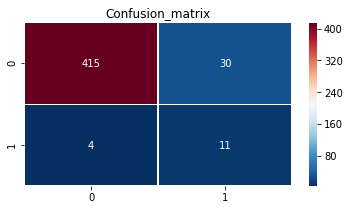

Recall:    0.7333333333333333
Precision: 0.2682926829268293
AUC:       0.46586499328169495


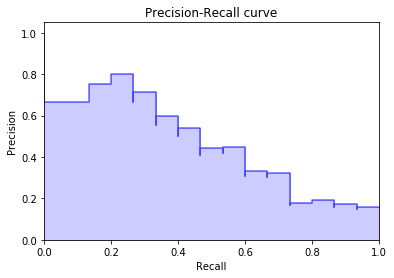

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       445
           1       0.27      0.73      0.39        15

   micro avg       0.93      0.93      0.93       460
   macro avg       0.63      0.83      0.68       460
weighted avg       0.97      0.93      0.94       460


----------- QDA w/ RUS -----------


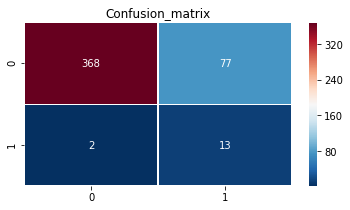

Recall:    0.8666666666666667
Precision: 0.14444444444444443
AUC:       0.34210472136861103


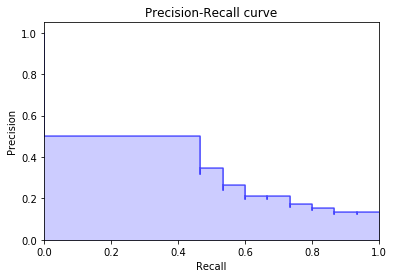

              precision    recall  f1-score   support

           0       0.99      0.83      0.90       445
           1       0.14      0.87      0.25        15

   micro avg       0.83      0.83      0.83       460
   macro avg       0.57      0.85      0.58       460
weighted avg       0.97      0.83      0.88       460


----------- QDA w/ NM -----------


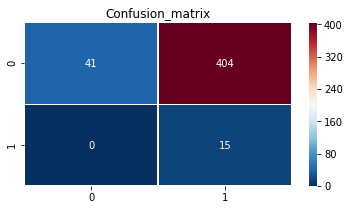

Recall:    1.0
Precision: 0.03579952267303103
AUC:       0.036585365853658534


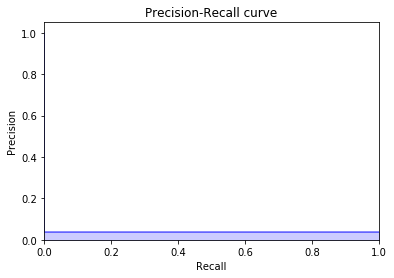

              precision    recall  f1-score   support

           0       1.00      0.09      0.17       445
           1       0.04      1.00      0.07        15

   micro avg       0.12      0.12      0.12       460
   macro avg       0.52      0.55      0.12       460
weighted avg       0.97      0.12      0.17       460


----------- QDA w/ CC -----------


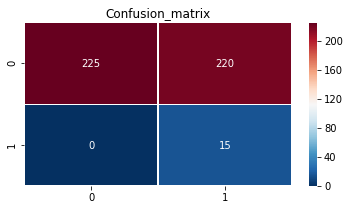

Recall:    1.0
Precision: 0.06382978723404255
AUC:       0.2708349063383508


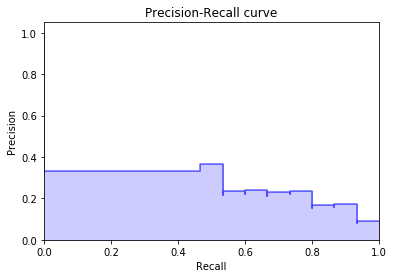

              precision    recall  f1-score   support

           0       1.00      0.51      0.67       445
           1       0.06      1.00      0.12        15

   micro avg       0.52      0.52      0.52       460
   macro avg       0.53      0.75      0.40       460
weighted avg       0.97      0.52      0.65       460


----------- QDA w/ ROS -----------


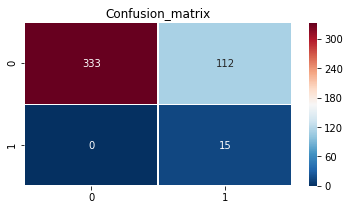

Recall:    1.0
Precision: 0.11811023622047244
AUC:       0.5317519879768067


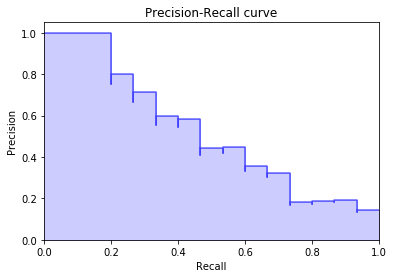

              precision    recall  f1-score   support

           0       1.00      0.75      0.86       445
           1       0.12      1.00      0.21        15

   micro avg       0.76      0.76      0.76       460
   macro avg       0.56      0.87      0.53       460
weighted avg       0.97      0.76      0.84       460


----------- QDA w/ SMOTE -----------


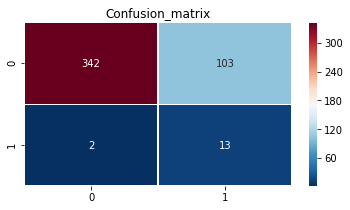

Recall:    0.8666666666666667
Precision: 0.11206896551724138
AUC:       0.5668850508539627


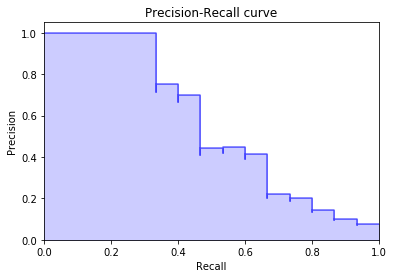

              precision    recall  f1-score   support

           0       0.99      0.77      0.87       445
           1       0.11      0.87      0.20        15

   micro avg       0.77      0.77      0.77       460
   macro avg       0.55      0.82      0.53       460
weighted avg       0.97      0.77      0.85       460


----------- QDA w/ SNN -----------


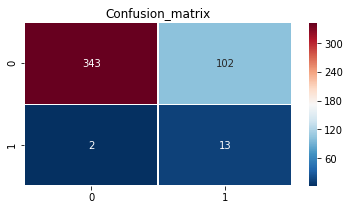

Recall:    0.8666666666666667
Precision: 0.11304347826086956
AUC:       0.42167099991980417


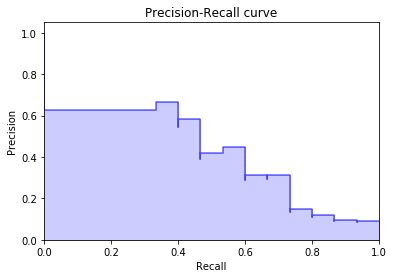

              precision    recall  f1-score   support

           0       0.99      0.77      0.87       445
           1       0.11      0.87      0.20        15

   micro avg       0.77      0.77      0.77       460
   macro avg       0.55      0.82      0.53       460
weighted avg       0.97      0.77      0.85       460


----------- QDA w/ STK -----------


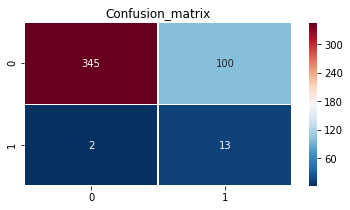

Recall:    0.8666666666666667
Precision: 0.11504424778761062
AUC:       0.5550805451768935


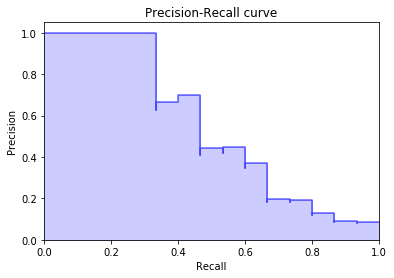

              precision    recall  f1-score   support

           0       0.99      0.78      0.87       445
           1       0.12      0.87      0.20        15

   micro avg       0.78      0.78      0.78       460
   macro avg       0.55      0.82      0.54       460
weighted avg       0.97      0.78      0.85       460



In [55]:
model = QuadraticDiscriminantAnalysis()

params = {                
          'reg_param' : [0.0, 0.001, 0.01, 0.05, 0.1, .5],
          'tol' : [0.0, 0.0001, 0.001, 0.01,0.1]
        }

qda_recall_scores = []
qda_auc_scores = []
for dataset in datasets:
    best_model = modelTune(model, params, dataset[1], dataset[2], scoring = 'recall')
    scores = modelReport("QDA", dataset[0], best_model, dataset[1],X_test,dataset[2],y_test, True, True)
    qda_recall_scores.append(scores[2])
    qda_auc_scores.append(scores[3])

In [56]:
print("QDA Recall Scores")
print(column_headers)
print(np.array(qda_recall_scores))

print("QDA AUC Scores")
print(column_headers)
print(np.array(qda_auc_scores))

QDA Recall Scores
['None', 'RUS', 'NM', 'CC', 'ROS', 'SMOTE', 'SNN', 'STK']
['0.73' '0.87' '1' '1' '1' '0.87' '0.87' '0.87']
QDA AUC Scores
['None', 'RUS', 'NM', 'CC', 'ROS', 'SMOTE', 'SNN', 'STK']
['0.47' '0.34' '0.037' '0.27' '0.53' '0.57' '0.42' '0.56']


Comparing our recall and cross validated scores we see that a highly tuned QDA model is certainly prone to overfitting, and may not be our best choice.

In [57]:
model = QuadraticDiscriminantAnalysis()

params = {                
          'reg_param' : [0.0, 0.001, 0.01, 0.05, 0.1, .5],
          'tol' : [0.0, 0.0001, 0.001, 0.01,0.1]
        }

for sampler in samplingMethods:
    cross_validate(model,"QDA", sampler[1], sampler[0], params, X_train.values, y_train.values)

-------QDA w/ RUS--------
Recall: 0.8838709677419354
Precision: 0.07920855862925295
AUC: 0.07361129600013579


-------QDA w/ NM--------
Recall: 0.8709677419354838
Precision: 0.03320187855255653
AUC: 0.03335300397392836


-------QDA w/ CC--------
Recall: 0.9483870967741936
Precision: 0.054777492679133434
AUC: 0.05358347334522948


-------QDA w/ ROS--------
Recall: 0.7612903225806452
Precision: 0.08990891898095585
AUC: 0.07639367367162356


-------QDA w/ SMOTE--------
Recall: 0.6580645161290323
Precision: 0.0866745668519124
AUC: 0.06852342110535806


-------QDA w/ SNN--------
Recall: 0.7290322580645161
Precision: 0.09702611830633535
AUC: 0.07996174648344734


-------QDA w/ STK--------
Recall: 0.6516129032258065
Precision: 0.08434686435164743
AUC: 0.0670106019004566




### Random Forest Classifier Tuning & Validation
In recent years, random forest has shown to be a strong classifier within the machine learning community. We'll tune our RF model and compare it with our cross validation scores to gauge how well the model generalizes.


----------- RF w/ No sampling -----------


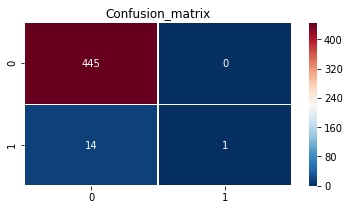

Recall:    0.06666666666666667
Precision: 1.0
AUC:       0.559273199434638


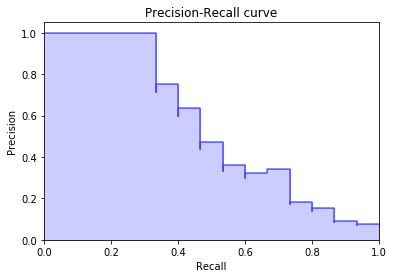

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       445
           1       1.00      0.07      0.12        15

   micro avg       0.97      0.97      0.97       460
   macro avg       0.98      0.53      0.55       460
weighted avg       0.97      0.97      0.96       460


----------- RF w/ RUS -----------


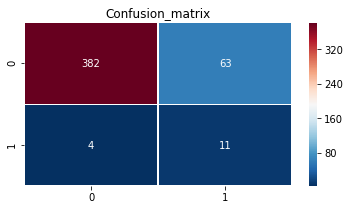

Recall:    0.7333333333333333
Precision: 0.14864864864864866
AUC:       0.5315271969693753


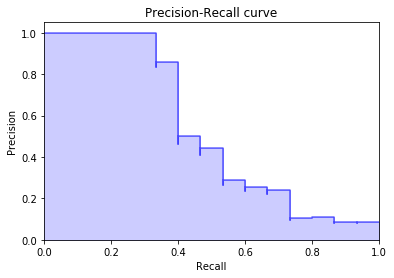

              precision    recall  f1-score   support

           0       0.99      0.86      0.92       445
           1       0.15      0.73      0.25        15

   micro avg       0.85      0.85      0.85       460
   macro avg       0.57      0.80      0.58       460
weighted avg       0.96      0.85      0.90       460


----------- RF w/ NM -----------


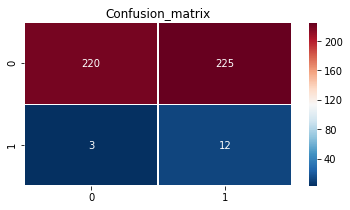

Recall:    0.8
Precision: 0.05063291139240506
AUC:       0.06953709311884168


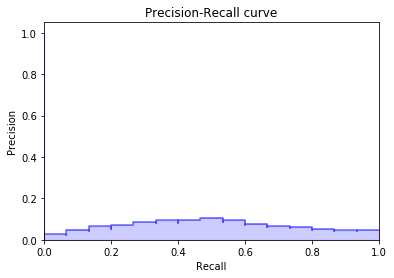

              precision    recall  f1-score   support

           0       0.99      0.49      0.66       445
           1       0.05      0.80      0.10        15

   micro avg       0.50      0.50      0.50       460
   macro avg       0.52      0.65      0.38       460
weighted avg       0.96      0.50      0.64       460


----------- RF w/ CC -----------


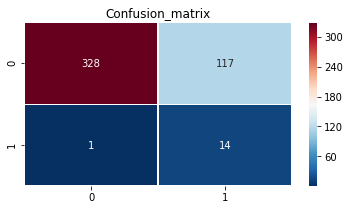

Recall:    0.9333333333333333
Precision: 0.10687022900763359
AUC:       0.44277833402970873


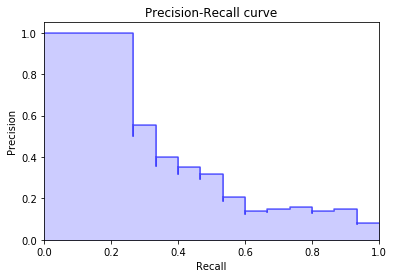

              precision    recall  f1-score   support

           0       1.00      0.74      0.85       445
           1       0.11      0.93      0.19        15

   micro avg       0.74      0.74      0.74       460
   macro avg       0.55      0.84      0.52       460
weighted avg       0.97      0.74      0.83       460


----------- RF w/ ROS -----------


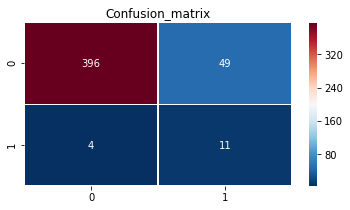

Recall:    0.7333333333333333
Precision: 0.18333333333333332
AUC:       0.5327813295796404


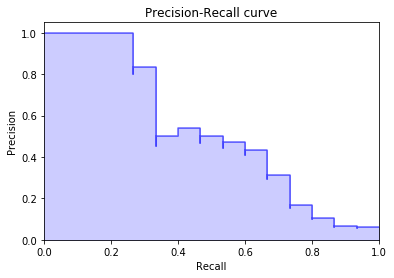

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       445
           1       0.18      0.73      0.29        15

   micro avg       0.88      0.88      0.88       460
   macro avg       0.59      0.81      0.62       460
weighted avg       0.96      0.88      0.92       460


----------- RF w/ SMOTE -----------


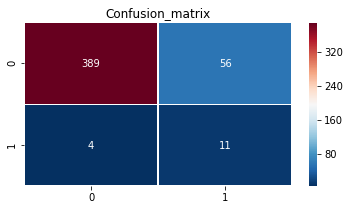

Recall:    0.7333333333333333
Precision: 0.16417910447761194
AUC:       0.5247437532028518


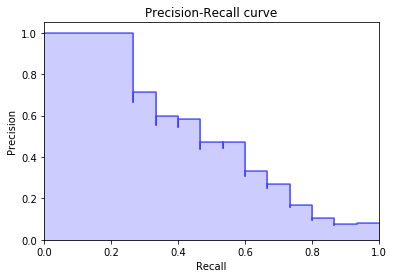

              precision    recall  f1-score   support

           0       0.99      0.87      0.93       445
           1       0.16      0.73      0.27        15

   micro avg       0.87      0.87      0.87       460
   macro avg       0.58      0.80      0.60       460
weighted avg       0.96      0.87      0.91       460


----------- RF w/ SNN -----------


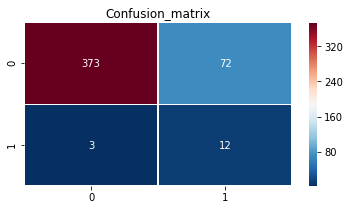

Recall:    0.8
Precision: 0.14285714285714285
AUC:       0.548462148677632


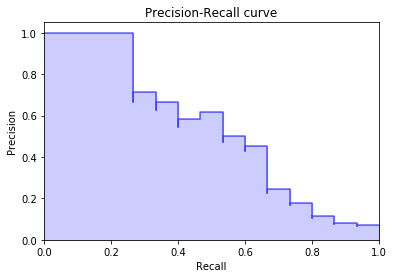

              precision    recall  f1-score   support

           0       0.99      0.84      0.91       445
           1       0.14      0.80      0.24        15

   micro avg       0.84      0.84      0.84       460
   macro avg       0.57      0.82      0.58       460
weighted avg       0.96      0.84      0.89       460


----------- RF w/ STK -----------


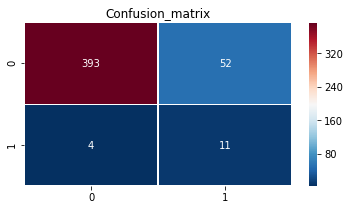

Recall:    0.7333333333333333
Precision: 0.1746031746031746
AUC:       0.5195757630433664


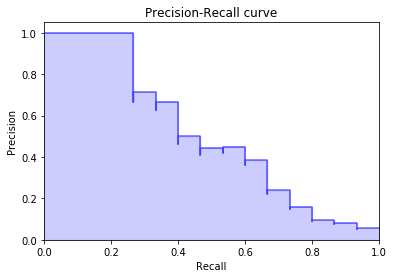

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       445
           1       0.17      0.73      0.28        15

   micro avg       0.88      0.88      0.88       460
   macro avg       0.58      0.81      0.61       460
weighted avg       0.96      0.88      0.91       460



In [61]:
model = RandomForestClassifier(random_state=2,n_estimators=100)
params = {
                "criterion": ["gini", "entropy"], 
                "max_depth": list(range(2,4,1)), 
                "min_samples_leaf": list(range(5,7,1))
               }

#name, sampling, model,X_train,X_test,y_train,y_test,isTuned, isEnsemble
rf_recall_scores = []
rf_auc_scores = []
for dataset in datasets:
    best_model = modelTune(model, params, dataset[1], dataset[2], scoring = 'recall')
    scores = modelReport("RF", dataset[0], best_model, dataset[1],X_test,dataset[2],y_test, True, True)
    rf_recall_scores.append(scores[2])
    rf_auc_scores.append(scores[3])

In [60]:
print("RF Recall Scores")
print(column_headers)
print(np.array(rf_recall_scores))

print("RF AUC Scores")
print(column_headers)
print(np.array(rf_auc_scores))

RF Recall Scores
['None', 'RUS', 'NM', 'CC', 'ROS', 'SMOTE', 'SNN', 'STK']
['0.13' '0.73' '0.87' '0.93' '0.73' '0.73' '0.8' '0.73']
RF AUC Scores
['None', 'RUS', 'NM', 'CC', 'ROS', 'SMOTE', 'SNN', 'STK']
['0.57' '0.57' '0.07' '0.44' '0.55' '0.52' '0.54' '0.51']


Now that we have our tuned model, let's compare it with our cross validation scores. Here we see that our recall and cross validated recall gravitate towards each other, indicating that our model is less prone to overfitting and is likely a good candidate. If we were to choose a model / resampling technique that works best, random forest decision classifier using random undersampling demonstrates a consistently high level of recall while maintaining a considerable level of precision. 

In [36]:
model = RandomForestClassifier(random_state=2,n_estimators=100)
params = {
                "criterion": ["gini", "entropy"], 
                "max_depth": list(range(2,4,1)), 
                "min_samples_leaf": list(range(5,7,1))
               }

for sampler in samplingMethods:
    cross_validate(model,"RF", sampler[1], sampler[0], params, X_train.values, y_train.values)

-------RF w/ RUS--------
Recall: 0.8516129032258064
Precision: 0.14907384968163706
AUC: 0.13066270058442192


-------RF w/ NM--------
Recall: 0.8451612903225806
Precision: 0.07815388029531098
AUC: 0.06917937313706957


-------RF w/ CC--------
Recall: 0.8838709677419356
Precision: 0.1027287169657048
AUC: 0.09515140090759791


-------RF w/ ROS--------
Recall: 0.6709677419354838
Precision: 0.2108907726377606
AUC: 0.15253754186563967


-------RF w/ SMOTE--------
Recall: 0.7354838709677419
Precision: 0.20454320524866015
AUC: 0.15900409446473077


-------RF w/ SNN--------
Recall: 0.7612903225806451
Precision: 0.19078812017963998
AUC: 0.15176373167011642


-------RF w/ STK--------
Recall: 0.6967741935483871
Precision: 0.20053191532554387
AUC: 0.15005753891641366


